# Undersampling

In [18]:
%run preprocessing_ccfd.ipynb

Zbog neravnoteže među klasama (sjetimo se da skup podataka sadrži 99.83% valjanih transakcija te 0.17% prevara) koristimo tehniku zvanu undersampling. Undersampling znači da od mnogobrojnije klase (valjane transakcije) uzimamo podskup podataka. U našem slučaju izdvajamo od svih valjanih transakcija u trening skupu njih 394 (jednako koliko je i prevara u trening skupu). <br> <b>Napomena</b>: Primjetimo da vršimo undersampling samo na trening skupu, testni skup i dalje ostaje isti <br>
To možemo postići na više načina, ovdje konkretno koristimo <i>RandomUnderSampler</i> (koji će nam automatski ujednačiti klase). Problem undersamplinga? <b>Gubitak informacija</b> (učimo na ~800 podataka, a bez undersamplinga bi učili na cijelom trening skupu koji ima ~220 000 podataka). Prednost undersamplinga? <b>Prepoznavanje prevara</b> (pošto su klase jednakobrojne model će lakše prepoznavati prevare).

In [2]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')
X_usample_train, y_usample_train = undersample.fit_resample(X_data_train, y_data_train)
y_usample_non_fraud_num = y_usample_train.value_counts()[0]
y_usample_fraud_num = y_usample_train.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_fraud_num + y_usample_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon undersamplinga: 394
Broj prevarantskih transakcija u trening skupu nakon undersamplinga: 394
Ukupan broj transakcija u trening skupu nakon undersamplinga: 788


In [37]:
%run functions.ipynb

## Logistička regresija

In [20]:
from sklearn.model_selection import cross_val_score
usample_log_reg = LogisticRegression(solver='liblinear')
usample_log_reg.fit(X_usample_train, y_usample_train)

usample_log_reg_training_score = cross_val_score(usample_log_reg, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: ' 
     + str(round(usample_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: 93.53%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.63%
	Recall score: 92.86%
	F1 score: 12.370000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


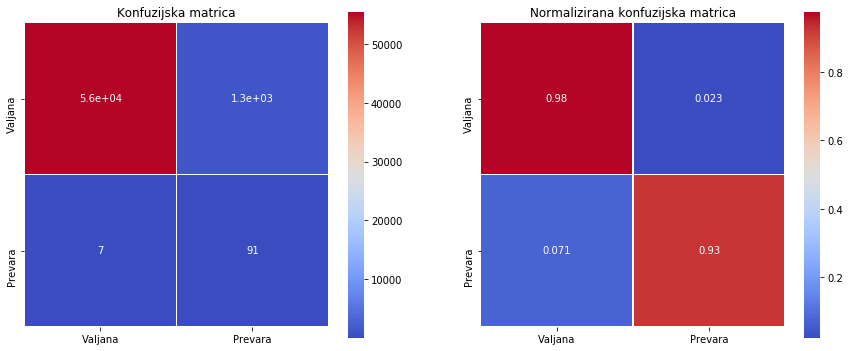

----------------------------------------------------------------------------------------------------


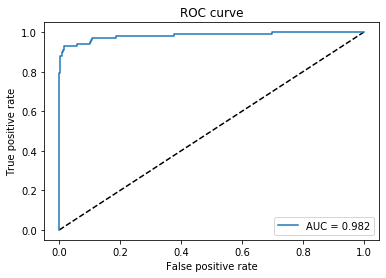

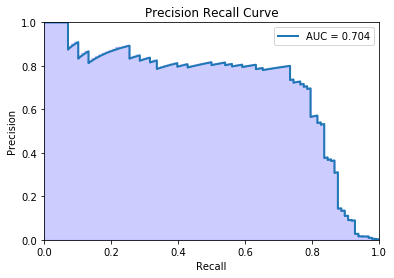

In [21]:
full_pred_log_reg = usample_log_reg.predict(X_data_test)
full_pred_score_log_reg = usample_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg, True)

Vidimo da smo s logističkom regresijom kao klasifikatorom dobili sljedeće rezultate. Preciznost (5.60%) i f1-mjera(10.56%) nisu najbolji rezultati. No cilj nam je točno klasificirati što više prevara, a ovaj model ih je točno klasificirao 90 prevara (od ukupno 98). Stoga je i osjetljivost dosta visoka (91.84%). Iz konfuzijske matrice možemo očitati i koji je razlog toga što su preciznost i f1-mjera dosta slabi, a to jest ~1500 transakcija koje su valjane, a model ih je klasificirao kao prevare. Također vidimo da je i površina ispod PR-krivulje 0.728. <br> Sada ćemo pokušati podesiti parametre i vidjeti kako će to utjecati na rezultate.

In [93]:
log_reg_c_params = [0.01, 0.1, 1, 10, 100]
log_reg_penalties = ['l1','l2']
log_reg_params = {"penalty": log_reg_penalties, 'C': log_reg_c_params}

In [94]:
grid_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg.fit(X_usample_train, y_usample_train)
log_reg_params_usample = grid_log_reg.best_estimator_
log_reg_params = grid_log_reg.best_params_
print('Najbolji parametri: ' + str(log_reg_params))

log_reg_training_score_params_usample = cross_val_score(log_reg_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 1, 'penalty': 'l1'}
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): 92.97999999999999%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.84%
	Recall score: 92.86%
	F1 score: 12.75%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


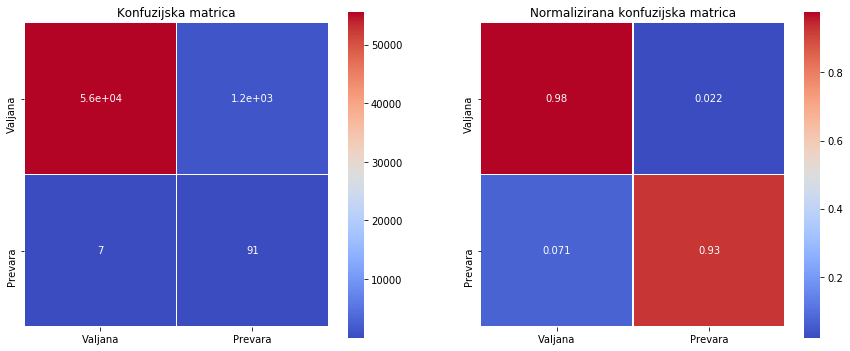

----------------------------------------------------------------------------------------------------


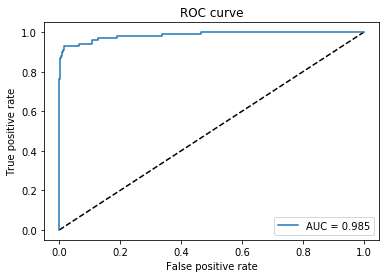

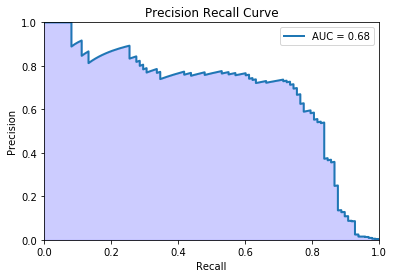

In [95]:
full_pred_log_reg_params = log_reg_params_usample.predict(X_data_test)
full_pred_score_log_reg_params = log_reg_params_usample.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params, True)

Vidimo da smo podešavanjem parametara dobili dosta bolje rezultate. I preciznost (6.06%) i f1-mjera (11.37%) su porasle, dok je osjetljivost pala na 90.82%. Kada usporedimo konfuzijsku matricu s prošlom vidjet ćemo i zašto. Novi model je pogrešno klasificirao ~1400 valjanih transakcija (prošli je imao ~1500). To znači da će ljudima koji će 'ručno' provjeravati te transakcije uštedjeti dosta posla (oko 100 transakcija), ali je zato i ispravno klasificirao 89 prevara (bilo je 90). Površina ispod PR-krivulje je nešto manja nego kod prošlog modela, ali to nije značajna razlika. <br> Još ćemo pokušati u klasifikator ubaciti težine klasa. Težinama omogućavamo klasifikatoru da bude pristraniji prema nekoj klasi.

****************************************************************************************************
Tezina klase 1 (prevare) je 0.1 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 64.05999999999999%
	Recall score: 83.67%
	F1 score: 72.57000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.84      0.73        98

    accuracy                           1.00     56962
   macro avg       0.82      0.92      0.86     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


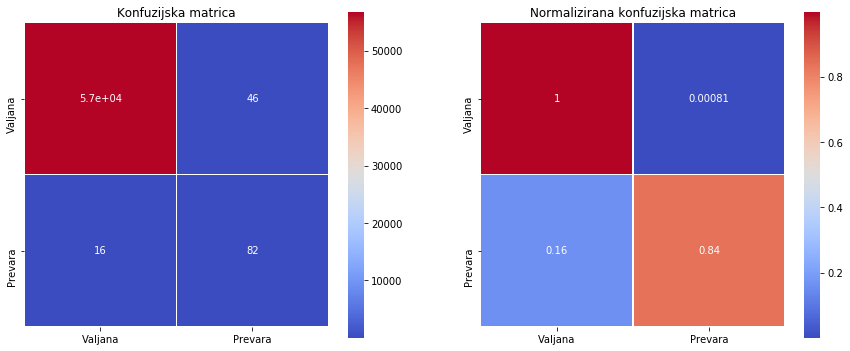

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.2 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 30.36%
	Recall score: 86.72999999999999%
	F1 score: 44.97%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.30      0.87      0.45        98

    accuracy                           1.00     56962
   macro avg       0.65      0.93      0.72     56962
weighted avg       1.00      1.00      1.00     56962


------------------------------------------------------------------------------------------------

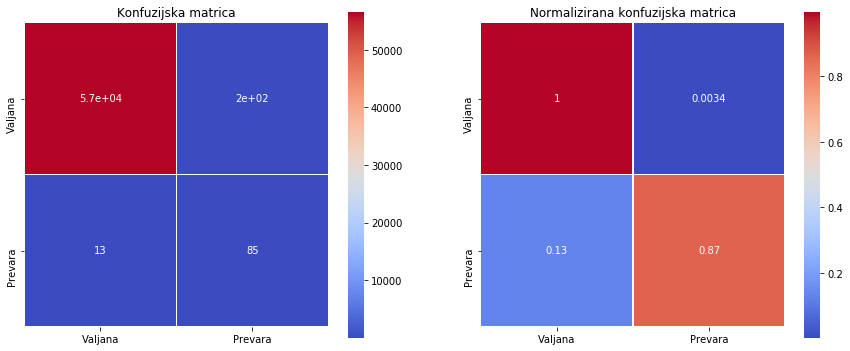

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.5 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 12.0%
	Recall score: 88.78%
	F1 score: 21.14%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.89      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


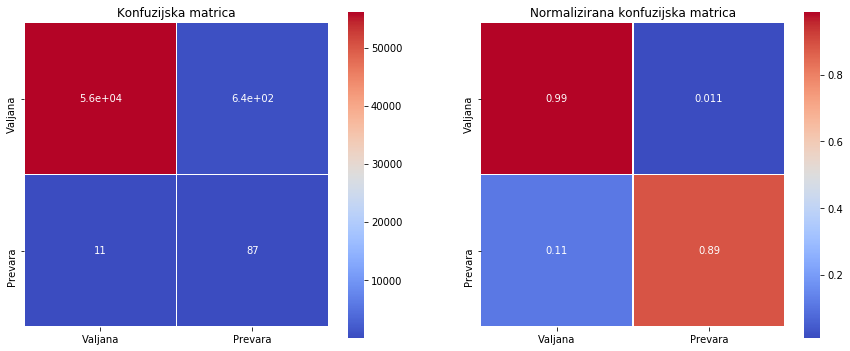

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.7 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.45%
	Recall score: 90.82000000000001%
	F1 score: 17.119999999999997%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


------------------------------------------------------------------------------------

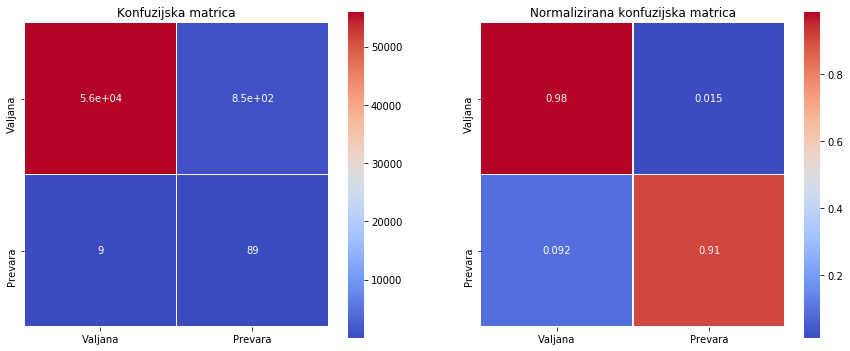

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 1 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.8500000000000005%
	Recall score: 92.86%
	F1 score: 12.76%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


-------------------------------------------------------------------------------------------------

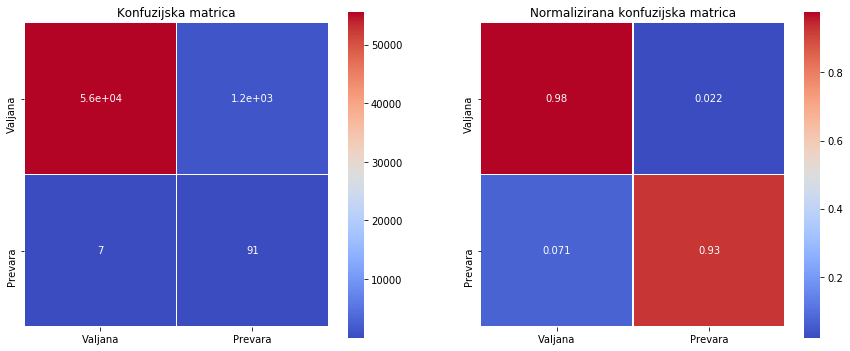

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 2 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.17%
	Recall score: 92.86%
	F1 score: 6.13%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.93      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


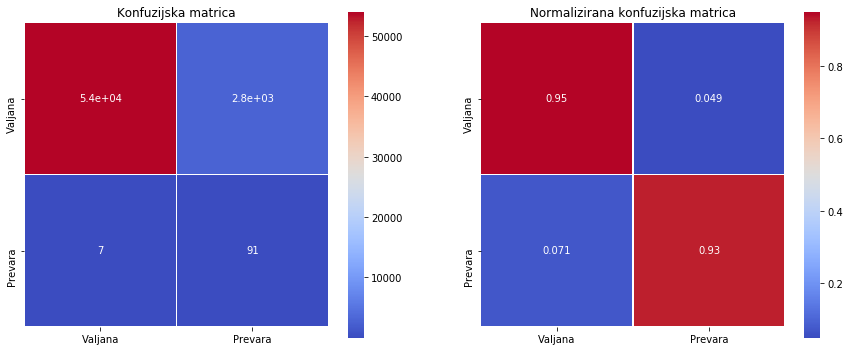

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 5 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.38%
	Recall score: 94.89999999999999%
	F1 score: 2.73%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56864
           1       0.01      0.95      0.03        98

    accuracy                           0.88     56962
   macro avg       0.51      0.92      0.48     56962
weighted avg       1.00      0.88      0.94     56962


----------------------------------------------------------------------------------------------------

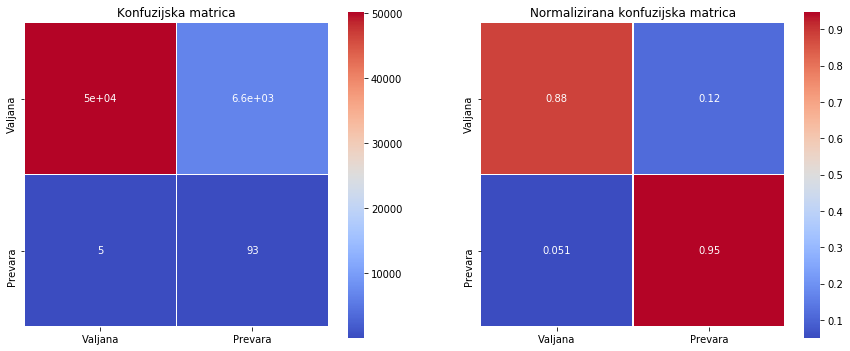

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 10 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.86%
	Recall score: 95.92%
	F1 score: 1.7000000000000002%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     56864
           1       0.01      0.96      0.02        98

    accuracy                           0.81     56962
   macro avg       0.50      0.88      0.46     56962
weighted avg       1.00      0.81      0.89     56962


-------------------------------------------------------------------------------------------------

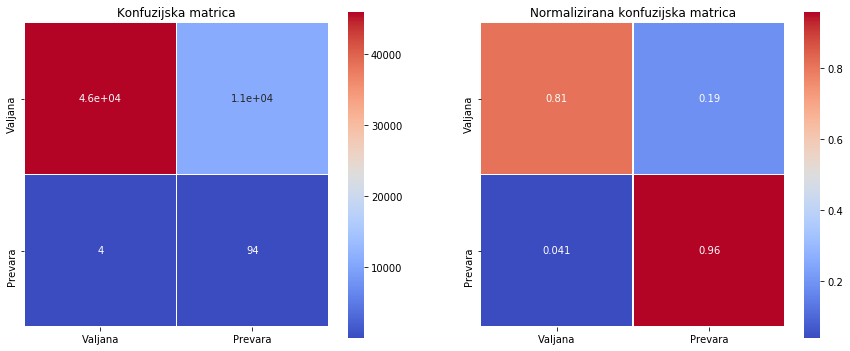

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 50 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.41000000000000003%
	Recall score: 97.96000000000001%
	F1 score: 0.8200000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.59      0.74     56864
           1       0.00      0.98      0.01        98

    accuracy                           0.59     56962
   macro avg       0.50      0.79      0.38     56962
weighted avg       1.00      0.59      0.74     56962


----------------------------------------------------------------------

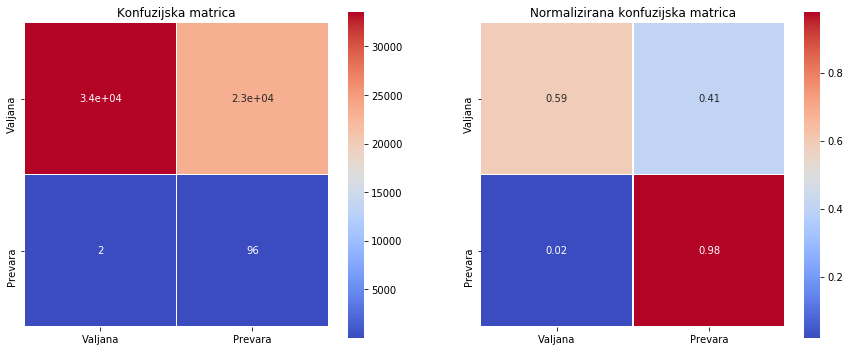

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 100 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.35000000000000003%
	Recall score: 97.96000000000001%
	F1 score: 0.69%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.51      0.68     56864
           1       0.00      0.98      0.01        98

    accuracy                           0.51     56962
   macro avg       0.50      0.75      0.34     56962
weighted avg       1.00      0.51      0.68     56962


-----------------------------------------------------------------------------------

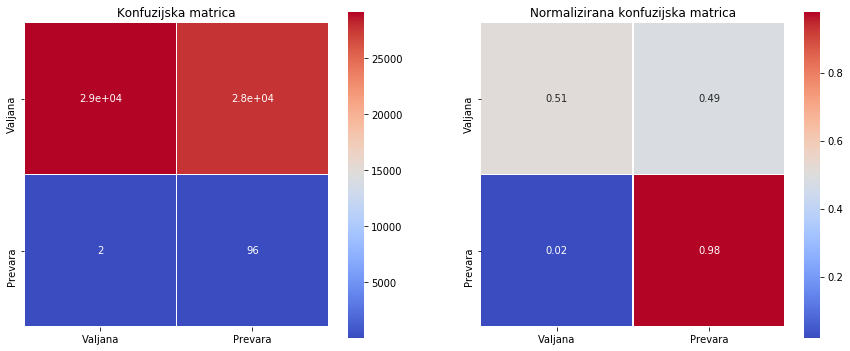

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 1000 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.21%
	Recall score: 100.0%
	F1 score: 0.41000000000000003%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.17      0.29     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.17     56962
   macro avg       0.50      0.59      0.15     56962
weighted avg       1.00      0.17      0.29     56962


----------------------------------------------------------------------------------------------

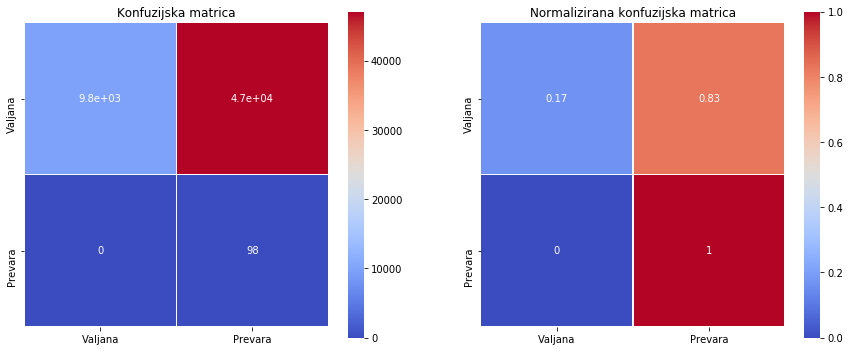

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 10000 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.18%
	Recall score: 100.0%
	F1 score: 0.35000000000000003%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.02      0.04     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.02     56962
   macro avg       0.50      0.51      0.02     56962
weighted avg       1.00      0.02      0.04     56962


---------------------------------------------------------------------------------------------

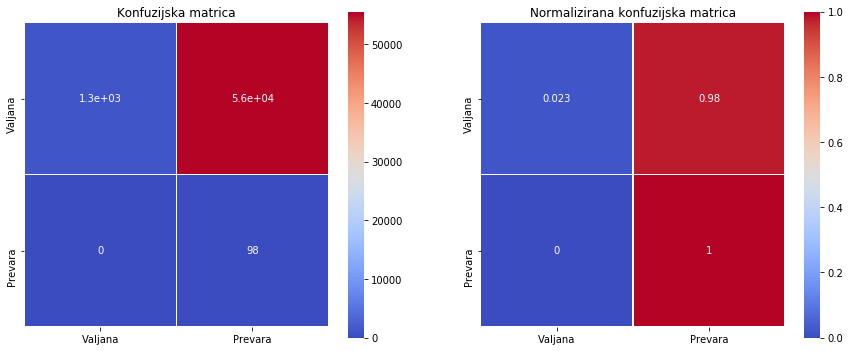

----------------------------------------------------------------------------------------------------


In [24]:

class_weights = [0.1, 0.2, 0.5, 0.7, 1, 2, 5, 10, 50, 100, 1000, 10000]
colors = ['blue', 'yellow', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'gold', 'lime', 'grey', 'black']
i = 0
precisions = []
recalls = []
fprs = []
tprs = []
aucs = []
aprcs = []


for weight in class_weights: 
    log_reg_weighted = LogisticRegression(C=log_reg_params['C'], 
                                          penalty=log_reg_params['penalty'],
                                          solver='liblinear', class_weight={0:1, 1:weight}
                                         )
    
    log_reg_weighted.fit(X_usample_train, y_usample_train)

    full_pred_w = log_reg_weighted.predict(X_data_test)
    full_score_w = log_reg_weighted.decision_function(X_data_test)
    print('*'*100)
    print('Tezina klase 1 (prevare) je ' + str(weight) + ' puta veća od klase 0 (valjane).' )
    print_everything(y_data_test, full_pred_w, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_w, False)
    
    precision, recall, threshold = precision_recall_curve(y_data_test, full_score_w)
    fpr, tpr, thold = roc_curve(y_data_test, full_score_w)
    area_under_curve = auc(fpr,tpr)
    au_pr_curve = auc(recall,precision)
    
    precisions.append(precision)
    recalls.append(recall)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(area_under_curve)
    aprcs.append(au_pr_curve)

Vidimo da kada podesimo težine dobijemo dosta drugačije rezultate (dosta veća preciznost i f1-mjera). Kada stavimo da je težina valjane klase vidimo da se kod modela drastično smanji broj pogrešno klasificiranih valjanih transakcija. Primjerice, kada je težine valjane klase 10 puta veća od klase prevara dobijemo svega 140 pogrešno klasificirane valjane transakcije (bez težina je bilo ~1400), što je značajan napredak. No, time smo i izgubili na broju ispravno klasificiranih prevara (sada ih je samo 82). Odnosno, 8 ljudi više nego prije će se 'izvuć' bez posljedica iako su nekom ukrali novac. <br> Isto tako kada je težina klase prevara 10 puta veća od klase valjana tada imamo jako nisku preciznost i f1-mjeru, ali je osjetljivost jako visoka (95.92%). Odnosno, sa takvim težinama model ispravno klasificira ispravno čak 94 prevar3. Doduše, isti model klasificira ~12000 valjanih transakcija kao prevare. <br> Od svih tih modela možemo odbrati onaj koji nam najviše odgovara (moežemo i detaljnije podesiti težine).

C:\Users\stvar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


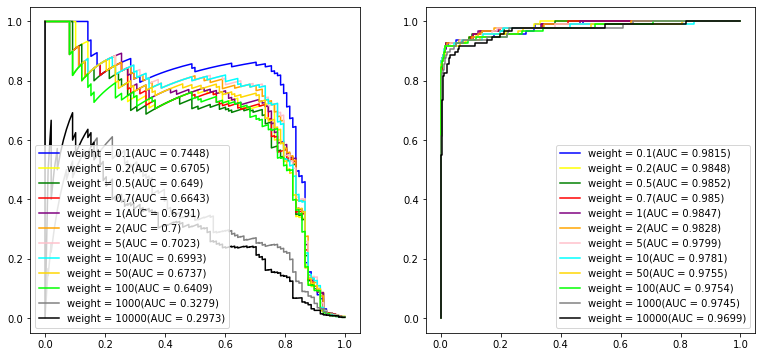

In [25]:
fig_w, ax_w = plt.subplots(1,2,figsize=(13,6))

for i in range(len(colors)):
    ax_w[0].plot(recalls[i], precisions[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aprcs[i], 4)) + ')')
    ax_w[1].plot(fprs[i], tprs[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aucs[i], 4)) + ')' )
ax_w[0].legend()
ax_w[1].legend()
plt.show()


Na slikama iznad vidimo i kako težine utječu na PR-krivulju (lijevo) i ROC-krivulju (desno).

## Stabla odluke

In [26]:
dt_usample = DecisionTreeClassifier()
dt_usample.fit(X_usample_train, y_usample_train)
dt_training_score_usample = cross_val_score(dt_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za stabla odluke nad undersampliranim datasetom: " + 
      str(round(dt_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za stabla odluke nad undersampliranim datasetom: 90.02%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.4000000000000001%
	Recall score: 91.84%
	F1 score: 2.75%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56864
           1       0.01      0.92      0.03        98

    accuracy                           0.89     56962
   macro avg       0.51      0.90      0.48     56962
weighted avg       1.00      0.89      0.94     56962


----------------------------------------------------------------------------------------------------


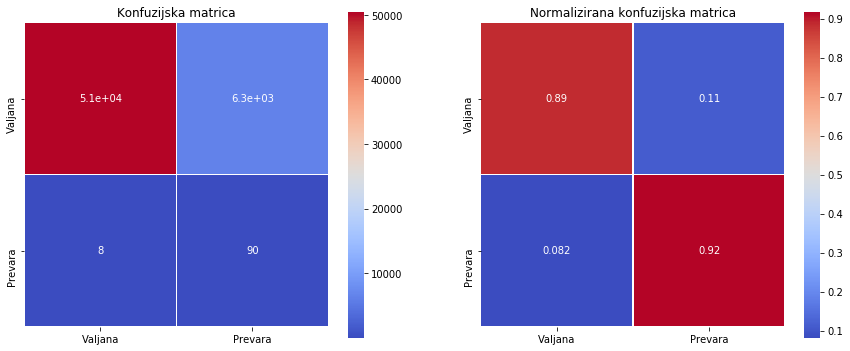

----------------------------------------------------------------------------------------------------


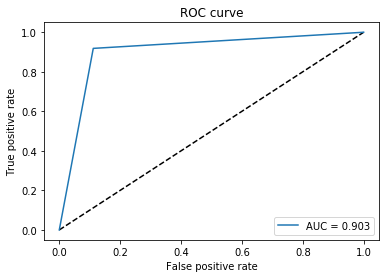

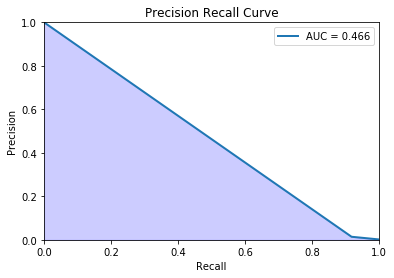

In [38]:
full_pred_dt = dt_usample.predict(X_data_test)
full_score_dt = dt_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_dt, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_dt, True)

Prvo što primjećujemo kod ovog modela je da su rezultati dosta slabiji. Vidimo da su preciznost (2.02%) i f1-mjera (3.96%) dosta manji nego kod logističke regresije. Ono što ovaj model čini dosta lošijim je što je uz to i osjetljivost slabija (91.84%). Kod matrice konfuzije prvo uočavamo da je pogrešno klasificirano čak ~4400 valjanih transakcija. Što je i više nego dvostruko koliko je model temeljen na logističkoj regresiji (bez parametara je bilo ~1500). Primjetimo i da ovaj model ima 90 ispravno klasificiranih prevara (kod logističke regresije je također bilo 90). <br> Pokušat ćemo i za ovaj model podesiti parametre pa vidjeti hoćemo li tako dobiti bolji model. 

In [28]:

grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params)
grid_dt.fit(X_usample_train, y_usample_train)
dt_params_usample = grid_dt.best_estimator_
dt_params_best = grid_dt.best_params_
print('Najbolji parametri: ' + str(dt_params_best))

dt_training_score_params_usample = cross_val_score(dt_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(dt_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'splitter': 'best'}
Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): 91.5%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.1%
	Recall score: 89.8%
	F1 score: 4.109999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56864
           1       0.02      0.90      0.04        98

    accuracy                           0.93     56962
   macro avg       0.51      0.91      0.50     56962
weighted avg       1.00      0.93      0.96     56962


----------------------------------------------------------------------------------------------------


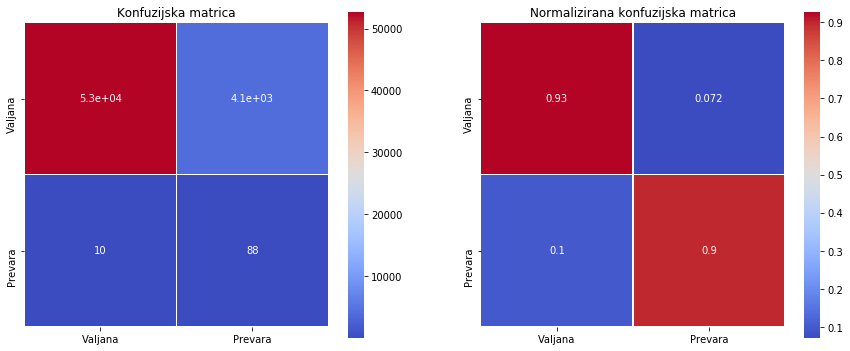

----------------------------------------------------------------------------------------------------


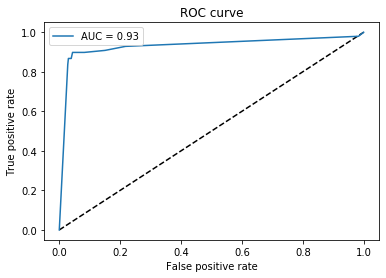

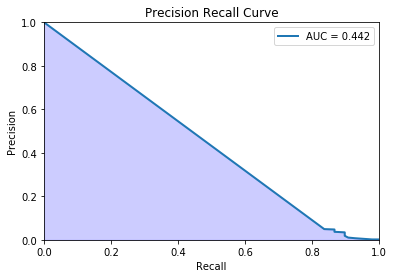

In [39]:
full_pred_dt_params = dt_params_usample.predict(X_data_test)
full_score_dt_params = dt_params_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_dt_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_dt_params, True)

Vidimo da smo ovdje dobili slabiji model. Preciznije, smanjili smo preciznost (1.83%) i f1-mjeru (3.58%), ali i osjetljivost (90.82%). Pomoću konfuzijske matrice vidimo da smo dobili ~4800 pogrešno klasificiranih transakcija (imali smo ~4400). 

## Bagging

In [30]:
bag_usample = BaggingClassifier()
bag_usample.fit(X_usample_train, y_usample_train)
bag_training_score_usample = cross_val_score(bag_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za bagging nad undersampliranim datasetom: " + 
      str(round(bag_training_score_usample.mean(), 4) * 100) + '%')


Rezultat treniranja za bagging nad undersampliranim datasetom: 92.93%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.04%
	Recall score: 90.82000000000001%
	F1 score: 7.739999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.91      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


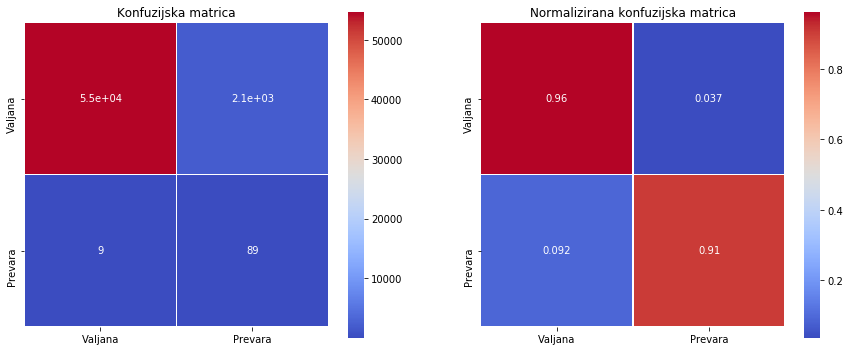

----------------------------------------------------------------------------------------------------


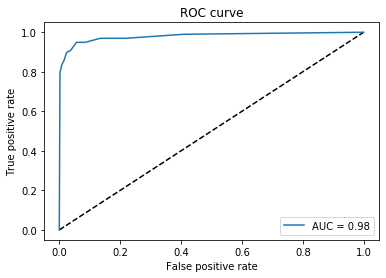

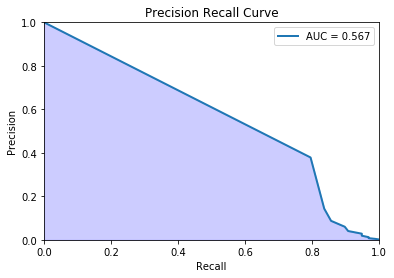

In [40]:
full_pred_bag = bag_usample.predict(X_data_test)
full_score_bag = bag_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_bag, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_bag, True)

Korištenjem bagginga (na stablima odluke) dobijamo dosta bolji rezultat nego korištenjem običnih stabala odluke. Vidimo da je ovaj model bolji u sve tri metrike. Odnosno, preciznost ovog modela je 5.55%, f1-mjera 10.47%, a osjetljivost 91.84%. Pomoću konfuzijske matrice vidimo da imamo 90 ispravno klasificiranih prevara (jednako kao i stabla odluke), odnosno jednu više nego na stablima odluke. Također ovaj model pogrešno klasificira ~ 1500 prevara (isto kao i model  logističe regresije ), dok je model na stablima odluke pogrešno klasificirao čak ~4400 (prije podešavanja parametara).

In [41]:
grid_bag = GridSearchCV(BaggingClassifier(), bag_params)
grid_bag.fit(X_usample_train, y_usample_train)
bag_params_usample = grid_bag.best_estimator_
bag_params_best = grid_bag.best_params_
print('Najbolji parametri: ' + str(bag_params_best))

bag_training_score_params_usample = cross_val_score(bag_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(bag_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 100}
Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): 93.4%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.4%
	Recall score: 90.82000000000001%
	F1 score: 10.190000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


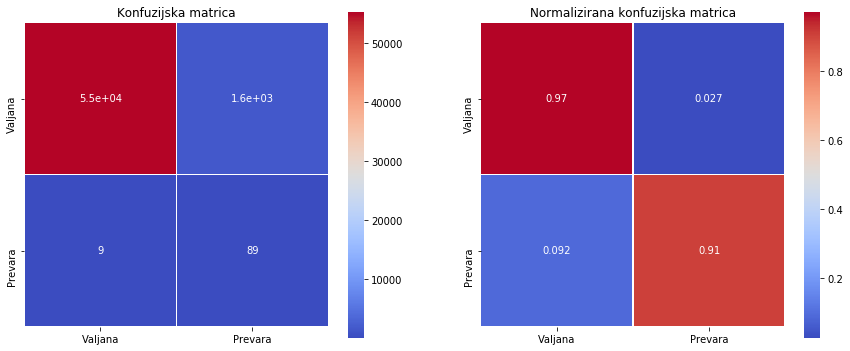

----------------------------------------------------------------------------------------------------


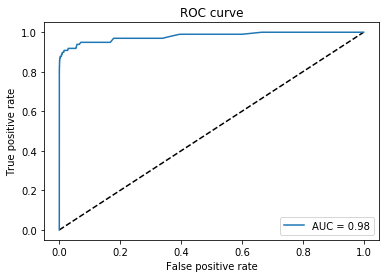

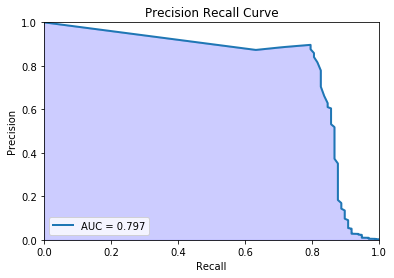

In [42]:
full_pred_bag_params = bag_params_usample.predict(X_data_test)
full_score_bag_params = bag_params_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_bag_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_bag_params, True)

Kao i u prijašnjim primjerima, podešavanje parametara je poboljšalo preciznost (7.34%) te f1-mjeru (13.59%), ali i smanjilo osjetljivost (90.82%). Preko konfuzijske matrice vidimo da je razlog tome pad u broj pogrešno klasificiranih valjanih transakcija (bilo je ~1500, sad je ~1100).

## Slučajne šume

In [43]:
rf_usample = RandomForestClassifier()
rf_usample.fit(X_usample_train, y_usample_train)
rf_training_score_usample = cross_val_score(rf_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za slučajne šume nad undersampliranim datasetom: " + 
      str(round(rf_training_score_usample.mean(), 4) * 100) + '%')


Rezultat treniranja za slučajne šume nad undersampliranim datasetom: 93.28%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.83%
	Recall score: 91.84%
	F1 score: 10.96%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


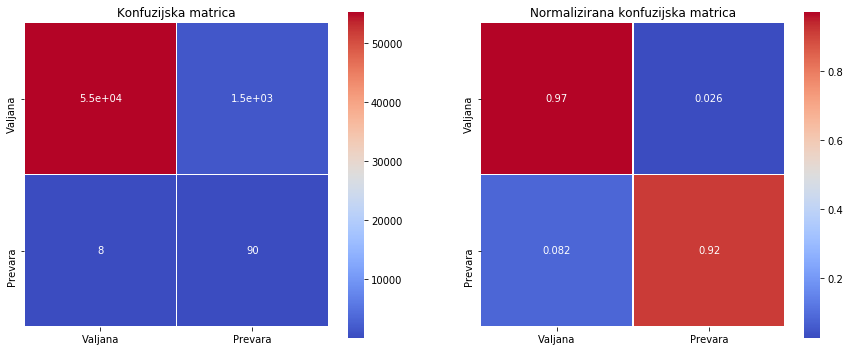

----------------------------------------------------------------------------------------------------


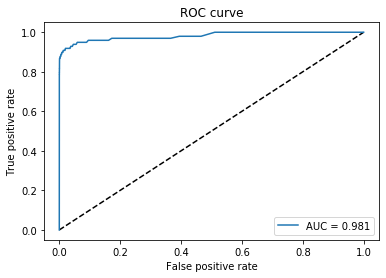

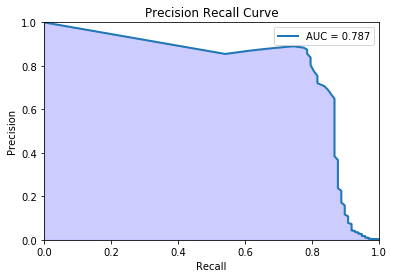

In [45]:
full_pred_rf = rf_usample.predict(X_data_test)
full_score_rf = rf_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_rf, True)

Ovaj model je dosad najbolji (bez parametara). Vidimo da ima dosad najvišu preciznost (8.04%) i f1-mjeru (14.77%), te jednaku osjetljivost (90.82%) kao i mnogi modeli prije. Preciznije, ovaj model kao i neki prethodni ima 89 ispravno klasificiranih prevara, dok ima i najmanje pogrešno klasificiranih valjanih transakcija (~1000).

In [46]:

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_usample_train, y_usample_train)
rf_params_usample = grid_rf.best_estimator_
rf_params_best = grid_rf.best_params_
print('Najbolji parametri: ' + str(rf_params_best))

rf_training_score_params_usample = cross_val_score(rf_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(rf_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7, 'n_estimators': 10}
Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): 92.81%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.56%
	Recall score: 91.84%
	F1 score: 10.48%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


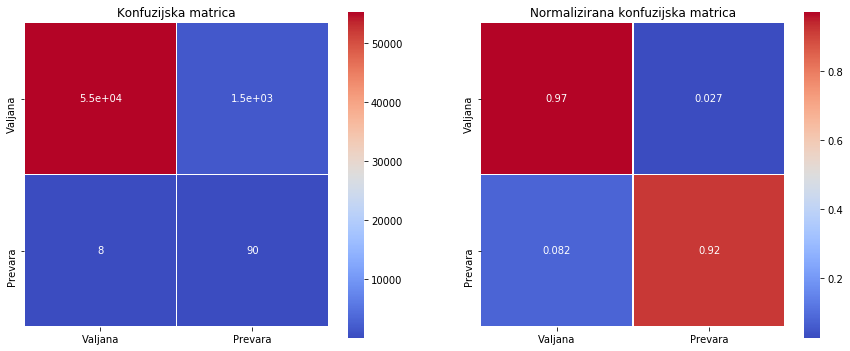

----------------------------------------------------------------------------------------------------


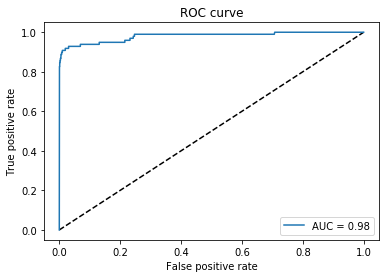

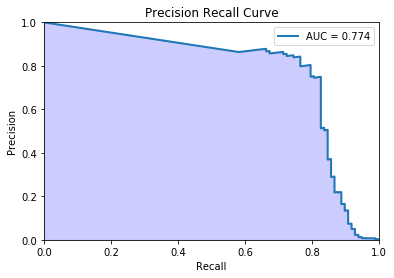

In [47]:
full_pred_rf_params = rf_params_usample.predict(X_data_test)
full_score_rf_params = rf_params_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_rf_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_rf_params, True)

Za razliku od prethodnih modela podešavanjem parametara kod slučajnih šuma nije poboljšalo rezultate testiranja ni u jednom aspektu (niti je pogoršalo).

## Metoda najbližih susjeda

In [48]:
knn_usample = KNeighborsClassifier()
knn_usample.fit(X_usample_train, y_usample_train)
knn_training_score_usample = cross_val_score(knn_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: " + 
      str(round(knn_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: 92.77%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.47%
	Recall score: 90.82000000000001%
	F1 score: 10.31%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


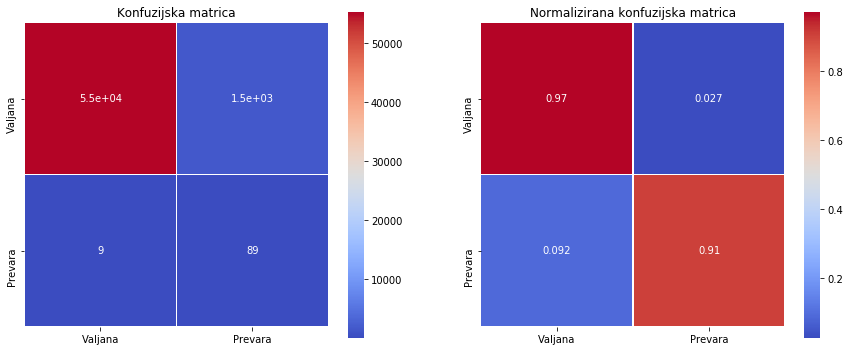

----------------------------------------------------------------------------------------------------


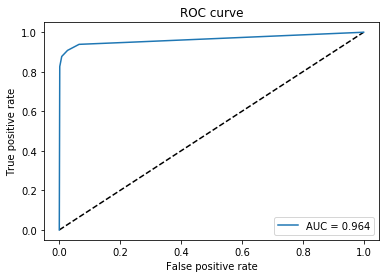

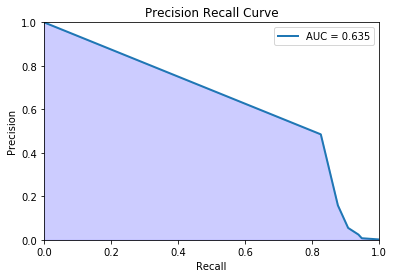

In [49]:
full_pred_knn = knn_usample.predict(X_data_test)
full_score_knn = knn_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_knn, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_knn, True)

Koristeći metodu najbližih susjeda dobili smo bolju preciznost (7.02%) i f1-mjeru (13.02%) u odnosu na većinu prethodnih klasifikatora, no također smo dobili i nešto lošiju osjetljivost (89.8%). Iz matrice konfuzije vidimo da osjetljivost nešto lošija nego kod prijašnjih klasifikatora zbog toga što je u ovom slučaju ispravno klasificirano 'samo' 88 prevara (dosad je bilo ili 89 ili 90). Doduše broj pogrešno klasificiranih valjanih transakcija je oko 1200, što je bolje od svih prethodnih klasifikatora osim slučajnih šuma. <br>
Sada ćemo podesiti parametre i vidjeti hoće li to imati ikakvog utjecaja na rezultate testiranja.

In [50]:

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_usample_train, y_usample_train)
knn_params_usample = grid_knn.best_estimator_
knn_params_best = grid_knn.best_params_
print('Najbolji parametri: ' + str(knn_params_best))

knn_training_score_params_usample = cross_val_score(knn_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za k (' +  str(knn_params_best['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(knn_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
Rezultat treniranja za k (5)  najbližih susjeda nad undersampliranim datasetom (sa parametrima): 93.15%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.47%
	Recall score: 90.82000000000001%
	F1 score: 10.31%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


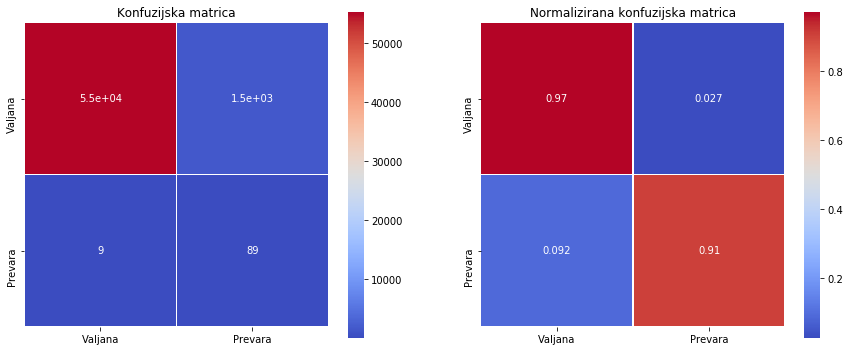

----------------------------------------------------------------------------------------------------


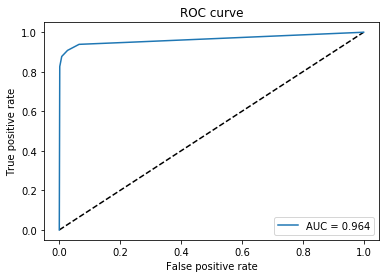

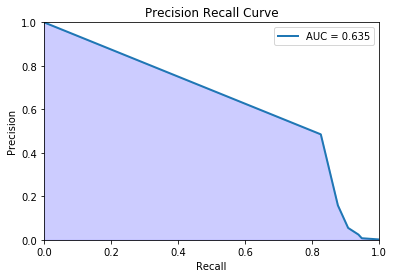

In [51]:
full_pred_knn_params = knn_params_usample.predict(X_data_test)
full_score_knn_params = knn_params_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_knn_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_knn_params, True)

Nakon podešavanja parametara dobili smo zanimljive rezultate. Odnosno, preciznost (10.55%) i f1-mjera su jako porasle (18.85%), a osjetljivost se malo smanjila (88.78%) u odnosu na model treniran bez parametara. Kada pogledamo matricu konfuzije vidimo da je broj pogrešno klasificiranih valjanih transakcija pao sa ~1200 na ~740 (najmanje dosad), ali se i smanjio broj ispravno klasificiranih prevara (bilo je 88, sad je 87).

## Metoda potpornih vektora

In [55]:
svc_usample = SVC(probability=True)
svc_usample.fit(X_usample_train, y_usample_train)
svc_training_score_usample = cross_val_score(svc_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: " + 
      str(round(svc_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: 92.51%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 10.03%
	Recall score: 88.78%
	F1 score: 18.029999999999998%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.89      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


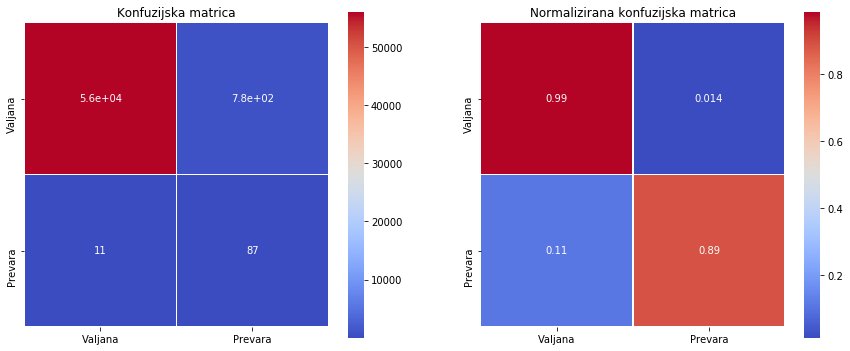

----------------------------------------------------------------------------------------------------


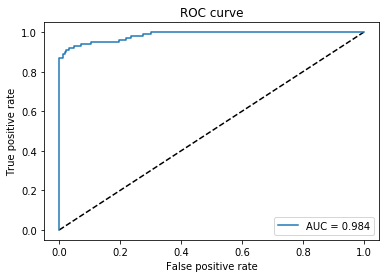

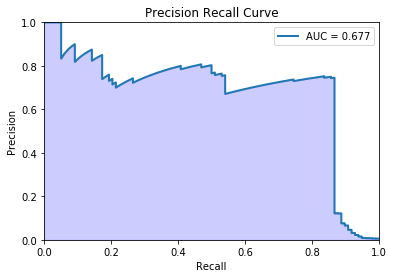

In [56]:
full_pred_svc = svc_usample.predict(X_data_test)
full_score_svc = svc_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_svc, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_svc, True)

Testiranjem na ovom modelu vidimo da smo dobili dosad najbolju (ako gledamo modele bez podešenih parametara) preciznost (9.67%) i f1-mjeru (17.43%), dok je osjetljivost 88.78%. Iz konfuzijske matrice vidimo da je model ispravno klasificirao 87 prevara (što je najmanje dosad), ali je također pogrešno klasificirao svega oko 810 valjanih transakcija (prvi koji ima manje od 1000).
<br> Pokušat ćemo pažljivo podesiti parametre pa vidjeti hoće li to dodatno popraviti rezultate.

In [57]:

grid_svc = GridSearchCV(SVC(probability=True), svc_params)
grid_svc.fit(X_usample_train, y_usample_train)
svc_params_usample = grid_svc.best_estimator_
svc_params_best = grid_svc.best_params_
print('Najbolji parametri: ' + str(svc_params_best))

svc_training_score_params_usample = cross_val_score(svc_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(svc_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): 93.11%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.62%
	Recall score: 91.84%
	F1 score: 15.76%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.92      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


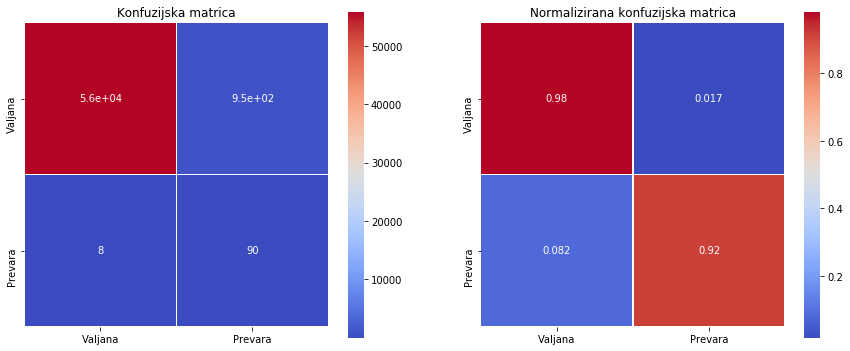

----------------------------------------------------------------------------------------------------


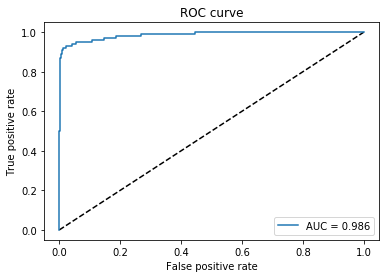

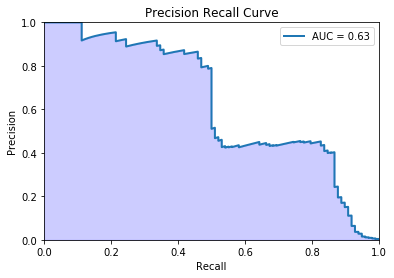

In [58]:
full_pred_svc_params = svc_params_usample.predict(X_data_test)
full_score_svc_params = svc_params_usample.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_svc_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_svc_params, True)

Podešavanje parametara je napravilo dosta za ovaj model. I preciznost (9.85%), i f1-mjera (17.76%), i osjetljivost (89.8%) su porasli. Nijedan od tih skokova nije velik, ali je ipak u sve tri kateogrije. Iz matrice konfuzije vidimo da imamo 88 ispravno klasificiranih prevara (bilo je 87), te ~800 pogrešno klasificiranih valjanih transakcija (bilo je ~800). 

## Boosting

Za boosting ćemo koristiti 4 različita algoritma te usporediti njihove rezultate. Algoritmi koje koristimo su:
<ol>
    <li>XGB (eXtreme Gradient Boosting)</li>
    <li>LGBM (Light Gradient Boosting Method)</li>
    <li>CatBoost (CATegorical Boosting)</li>
    <li>AdaBoost (ADAptive Boosting)</li>
</ol>

In [59]:
print("XGB (eXtreme Gradient Boosting)")
xgb_usample = XGBClassifier()
xgb_usample.fit(X_usample_train, y_usample_train)
xgb_usample_training_score = cross_val_score(xgb_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: " + 
       str(round(xgb_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
lgbm_usample = LGBMClassifier()
lgbm_usample.fit(X_usample_train, y_usample_train)
lgbm_usample_training_score = cross_val_score(lgbm_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: " + 
       str(round(lgbm_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("CatBoost (CATegorical Boosting)")
cat_usample = CatBoostClassifier(silent=True)
cat_usample.fit(X_usample_train, y_usample_train)
cat_usample_training_score = cross_val_score(cat_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: " + 
       str(round(cat_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("AdaBoost (ADAptive Boosting)")
ada_usample = AdaBoostClassifier()
ada_usample.fit(X_usample_train, y_usample_train)
ada_usample_training_score = cross_val_score(ada_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: " + 
       str(round(ada_usample_training_score.mean(), 4) * 100) + '%')

XGB (eXtreme Gradient Boosting)
Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: 93.91000000000001%
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: 93.65%
----------------------------------------------------------------------------------------------------
CatBoost (CATegorical Boosting)
Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: 93.4%
----------------------------------------------------------------------------------------------------
AdaBoost (ADAptive Boosting)
Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: 92.60000000000001%


****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.19%
	Recall score: 92.86%
	F1 score: 9.83%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


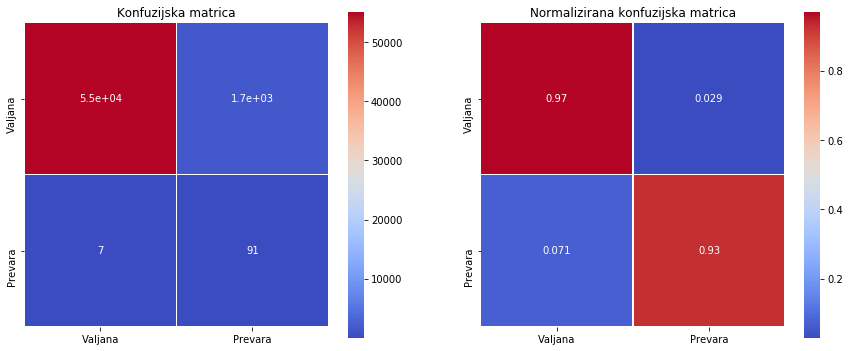

----------------------------------------------------------------------------------------------------


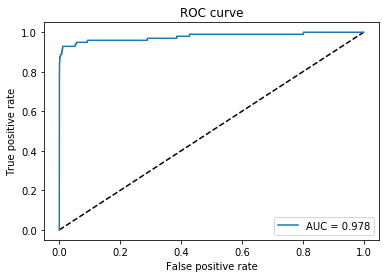

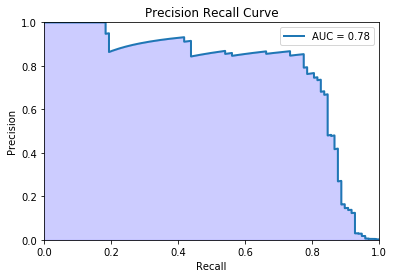

----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.9799999999999995%
	Recall score: 92.86%
	F1 score: 9.46%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


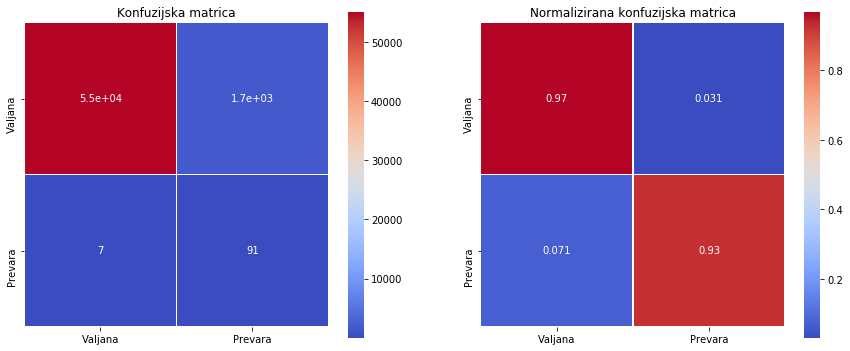

----------------------------------------------------------------------------------------------------


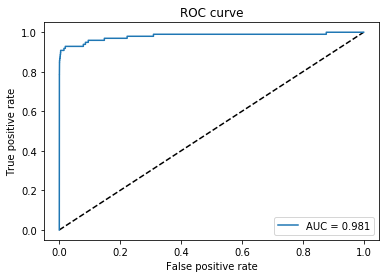

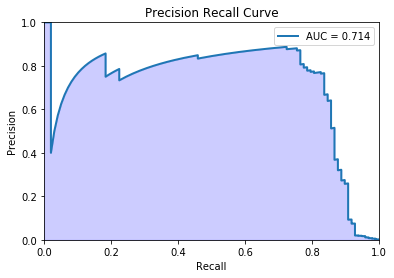

----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.88%
	Recall score: 91.84%
	F1 score: 11.06%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


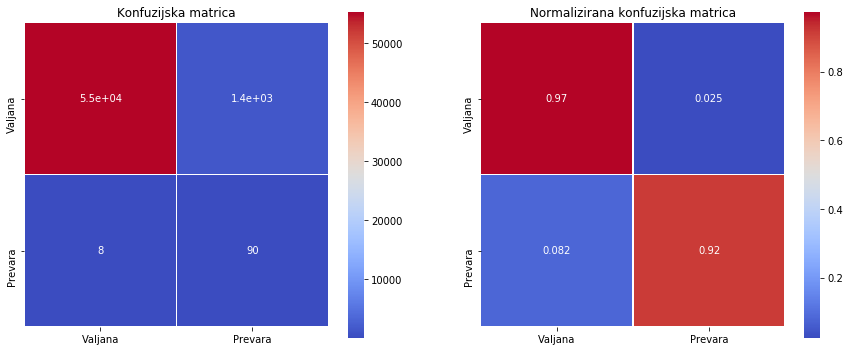

----------------------------------------------------------------------------------------------------


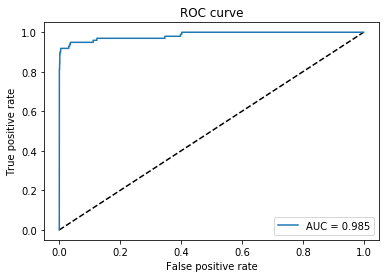

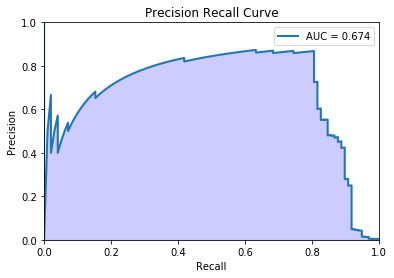

----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.93%
	Recall score: 91.84%
	F1 score: 5.680000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.92      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


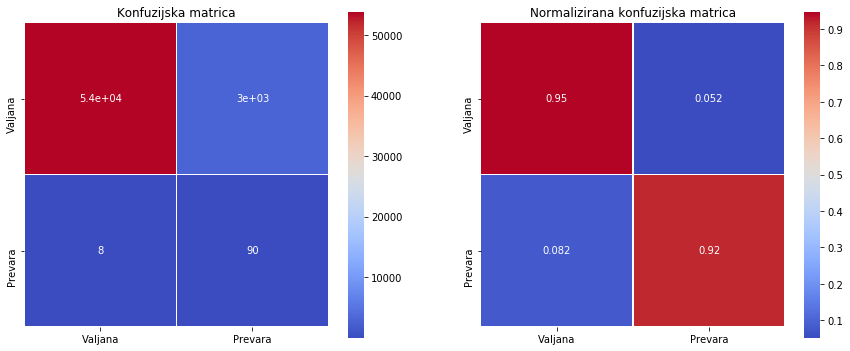

----------------------------------------------------------------------------------------------------


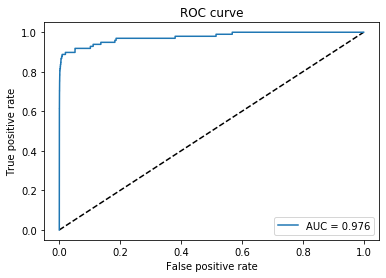

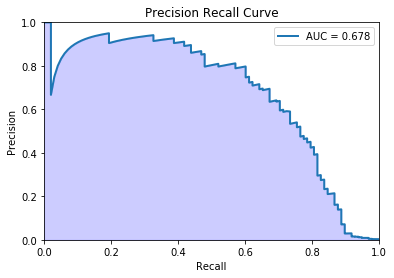

****************************************************************************************************


In [60]:
full_pred_xgb = xgb_usample.predict(X_data_test)
full_score_xgb = xgb_usample.predict_proba(X_data_test)[:, 1]

full_pred_lgbm = lgbm_usample.predict(X_data_test)
full_score_lgbm = lgbm_usample.predict_proba(X_data_test)[:, 1]

full_pred_cat = cat_usample.predict(X_data_test)
full_score_cat = cat_usample.predict_proba(X_data_test)[:, 1]

full_pred_ada = ada_usample.predict(X_data_test)
full_score_ada = ada_usample.predict_proba(X_data_test)[:, 1]

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_xgb, True)
print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
print_everything(y_data_test, full_pred_lgbm, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_lgbm, True)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_cat, True)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_ada, True)
print('*'*100)

Prokomentirajmo sada rezultate. <br>
<ol>
    <li><em>XGB</em>
        <p>Koristeći XGB dobili smo jako dobre rezultate testiranja. Preciznost je 5.54%, f1-mjera 10.45%, a osjetljivost je vrlo visokih 92.86%. Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1600 valjanih transakcija (što je bolje od većine algoritama dosad), dok je ispravno klasificirano čak 91 prevara (što je najviše dosad).</p>
    </li><br><hr>
    <li><em>LGBM</em>
        <p>Korištenjem LGBM-a smo također dobili jako dobre rezultate. Preciznost (5.7%) i f1-mjera(10.73%) su malo viši nego kod XGB-a, dok je osjetljivost (91.84%) malo niža. Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1500 valjanih transakcija (stotinjak manje nego kod XGB-a), dok je ispravno klasificirano 90 prevara (jedna manje nego kod XGB-a).</p>
    </li><br><hr>
    <li><em>CatBoost</em>
        <p>Sljedeći algoritam boostinga je CatBoost. Njime smo dobili još bolje rezultate nego LGBM-om. Tako je u ovom slučaju preciznost čak 8.29%, a f1-mjera 15.22%, dok je osjetljivost 91.84% (isto kao i kod LGBM-a). Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1000 valjanih transakcija (petstotinjak manje nego kod LGBM-a, odnosno trećina manje), dok je ispravno klasificirano 90 prevara (isto kao i kod LGBM-a). </p>
    </li><br><hr>
    <li><em>AdaBoost</em>
        <p>Posljednji algoritam boostinga koji koristimo je AdaBoost. On se pokazao kao najslabiji od boosting algoritama. U ovom slučaju preciznost samo 2.86%, a f1-mjera 5.55%, dok je osjetljivost 91.84% (isto kao i kod LGBM-a, te CatBoosta). Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 3100 valjanih transakcija (triput više nego kod CatBoosta), dok je ispravno klasificirano 90 prevara (isto kao i kod CatBoosta). </p>
    </li>
    
    
</ol>
<br> <hr>
Sada ćemo za sva 4 boosting algoritma podesiti parametre te vidjeti kako će to utjecati na rezultate.


In [61]:
grid_xgb = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb.fit(X_usample_train, y_usample_train)
xgb_params_usample = grid_xgb.best_estimator_
xgb_params_best = grid_xgb.best_params_

In [62]:

grid_lgbm = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm.fit(X_usample_train, y_usample_train)
lgbm_params_usample = grid_lgbm.best_estimator_
lgbm_params_best = grid_lgbm.best_params_

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", li

In [63]:

grid_cat = GridSearchCV(CatBoostClassifier(silent=True), cat_params)
grid_cat.fit(X_usample_train, y_usample_train)
cat_params_usample = grid_cat.best_estimator_
cat_params_best = grid_cat.best_params_


In [64]:
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
grid_ada.fit(X_usample_train, y_usample_train)
ada_params_usample = grid_ada.best_estimator_
ada_params_best = grid_ada.best_params_

In [65]:
xgb_training_score_params_usample = cross_val_score(xgb_params_usample, X_usample_train, y_usample_train, cv=rskf)
lgbm_training_score_params_usample = cross_val_score(lgbm_params_usample, X_usample_train, y_usample_train, cv=rskf)
cat_training_score_params_usample = cross_val_score(cat_params_usample, X_usample_train, y_usample_train, cv=rskf)
ada_training_score_params_usample = cross_val_score(ada_params_usample, X_usample_train, y_usample_train, cv=rskf)

print('Treniranje (sa parametrima)')
print('-'*100)
print('XGB')
print('Najbolji parametri: ' + str(xgb_params_best))
print('Rezultat treniranja: ' + str(round(xgb_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('LGBM')
print('Najbolji parametri: ' + str(lgbm_params_best))
print('Rezultat treniranja: ' + str(round(lgbm_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('CatBoost')
print('Najbolji parametri: ' + str(cat_params_best))
print('Rezultat treniranja: ' + str(round(cat_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('AdaBoost')
print('Najbolji parametri: ' + str(ada_params_best))
print('Rezultat treniranja: ' + str(round(ada_training_score_params_usample.mean(), 4) * 100) + '%')


Treniranje (sa parametrima)
----------------------------------------------------------------------------------------------------
XGB
Najbolji parametri: {'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Rezultat treniranja: 93.7%
----------------------------------------------------------------------------------------------------
LGBM
Najbolji parametri: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
Rezultat treniranja: 93.49%
----------------------------------------------------------------------------------------------------
CatBoost
Najbolji parametri: {'depth': 5, 'learning_rate': 0.3, 'n_estimators': 10}
Rezultat treniranja: 93.53%
----------------------------------------------------------------------------------------------------
AdaBoost
Najbolji parametri: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'base_estimator__splitter': 'best', 'learning_

****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.16%
	Recall score: 92.86%
	F1 score: 9.78%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


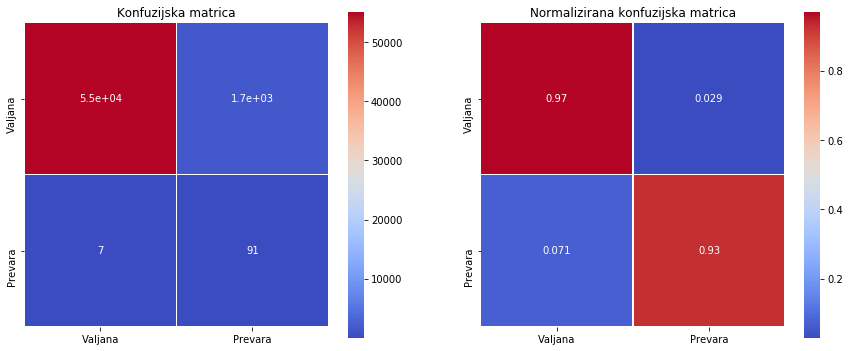

----------------------------------------------------------------------------------------------------


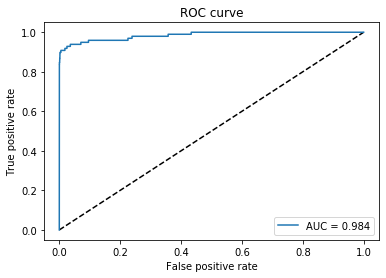

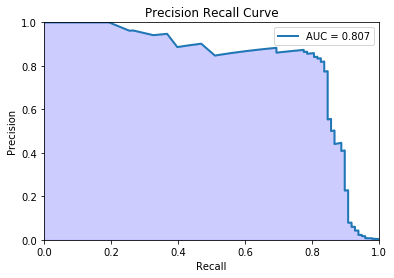

----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Machine)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.75%
	Recall score: 93.88%
	F1 score: 9.049999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.94      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


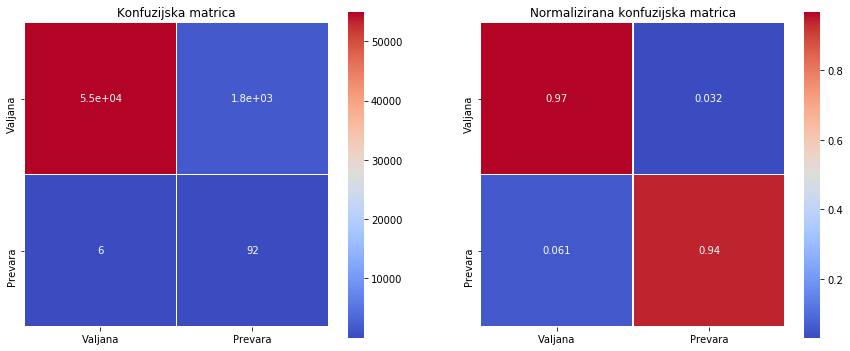

----------------------------------------------------------------------------------------------------


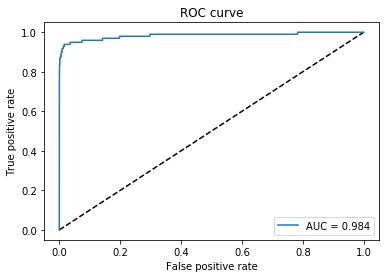

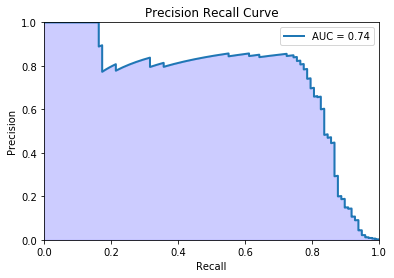

----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.07%
	Recall score: 92.86%
	F1 score: 9.62%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


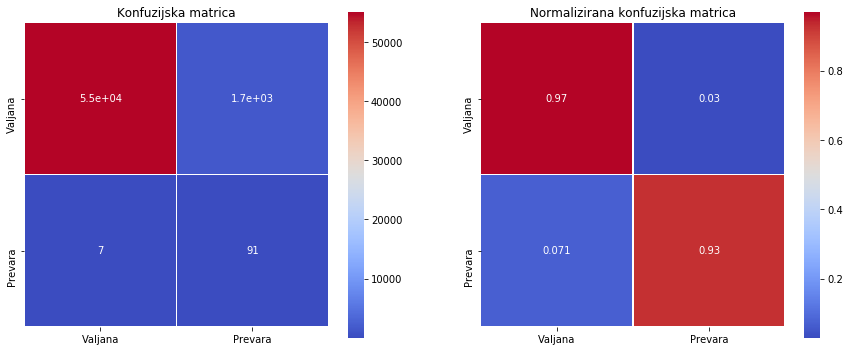

----------------------------------------------------------------------------------------------------


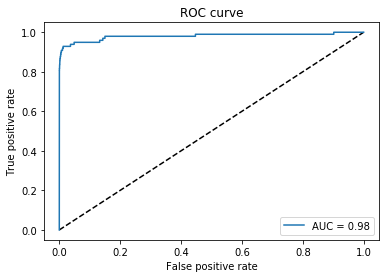

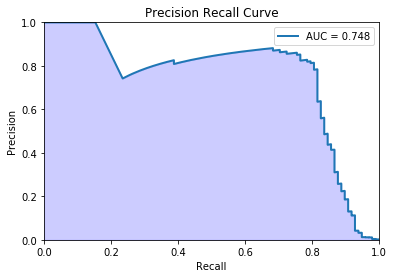

----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.66%
	Recall score: 92.86%
	F1 score: 8.88%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


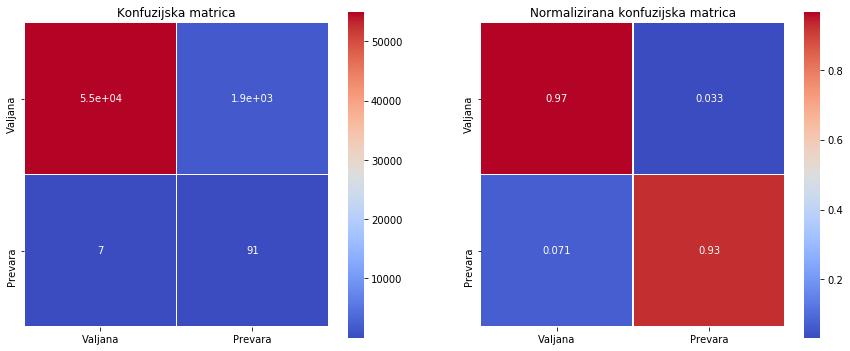

----------------------------------------------------------------------------------------------------


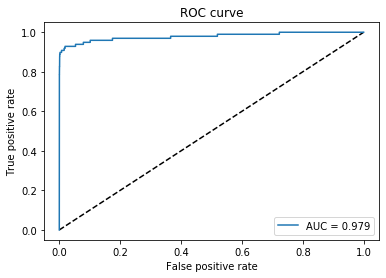

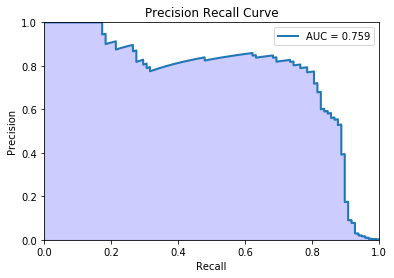

****************************************************************************************************


In [66]:
full_pred_xgb_params = xgb_params_usample.predict(X_data_test)
full_score_xgb_params = xgb_params_usample.predict_proba(X_data_test)[:, 1]

full_pred_lgbm_params = lgbm_params_usample.predict(X_data_test)
full_score_lgbm_params = lgbm_params_usample.predict_proba(X_data_test)[:, 1]

full_pred_cat_params = cat_params_usample.predict(X_data_test)
full_score_cat_params = cat_params_usample.predict_proba(X_data_test)[:, 1]

full_pred_ada_params = ada_params_usample.predict(X_data_test)
full_score_ada_params = ada_params_usample.predict_proba(X_data_test)[:, 1]

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_xgb_params, True)
print('-'*100)
print("LGBM (Light Gradient Boosting Machine)")
print_everything(y_data_test, full_pred_lgbm_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_lgbm_params, True)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_cat_params, True)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_ada_params, True)
print('*'*100)

Prokomentirajmo sada rezultate. <br>
<ol>
    <li><em>XGB</em>
        <p>Nakon podešavanja parametara XGB je ponovno imao dobre rezultate. Preciznost (5.23%) i f1-mjera (9.91%) su se malo smanjile u odnosu na model bez parametara, no zato je osjetljivost porasla (sada je 93.88%). Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao čak 92 prevare, dok je pogrešno klasificirao oko 1700 valjanih transakcija. U odnosu na model bez parametara sada imamo 1 ispravno klasificiranu prevaru više, te stotinjak pogrešno klasificiranih valjanih transakcija više. </p>
    </li><br><hr>
    <li><em>LGBM</em>
        <p>Podešavanjem parametara kod LGBM-a smo dobili vidljivo bolje rezultate. I preciznost (7.94%) i f1-mjera (14.63%) su se poboljšale, no zanimljivo je da je i osjetljivost (92.86%) porasla. Iz matrice konfuzije vidimo da sada imamo 91 ispravno klasificiranu prevaru (bez parametara je bilo 90) te svega oko 1100 pogrešno klasificiranih valjanih transakcija (bez parametara je bilo oko 1500). Znači model je bolji od onog bez parametara u svim kategorijama.</p>
    </li><br><hr>
    <li><em>CatBoost</em>
        <p> Kod CatBoosta smo dobili solidne rezultate. I ovdje su i preciznost (9.13%) i f1-mjera (16.59%) porasle, no osjetljivost (90.82%) je malo pala. Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao 89 prevara (jednu manje u odnosu na model bez parametara), ali je pogrešno klasificirao samo ~890 valjanih transakcija (oko 110 manje nego bez parametara). </p>
    </li><br><hr>
    <li><em>AdaBoost</em>
        <p>Adaboost je algoritam koji se podeašavanjem parametara najznačajnije popravio. I preciznost (8.79%) i f1-mjera (16.02%) su jako skočile (preciznost je bila 2.86%, a f1-mjera 5.55%). Osjetljivost je doduše blago pala i sad je 90.82%. Iz matrice konfuzije vidimo da je model ispravno klasificirao 89 prevara (samo jednu manje nego model bez parametara), dok je pogrešno klasificirao svega ~920 valjanih transakcija (bilo je čak ~3100). </p>
    </li> 
</ol>



## Metoda klasifikcije glasanjem

Zadnji klasifikator koji ćemo koristiti je klasifikacija glasanjem. Promatrat ćemo 11 različitih klasifikatora.
<ol>
    <li><em>Prvi glasački klasifikator (1)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Drugi glasački klasifikator (2)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
        </ul>
    </li> <hr>
    <li><em>Treći glasački klasifikator (3)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
            <li>Metoda najbližih susjeda
        </ul>
    </li> <hr>
    <li><em>Četvrti glasački klasifikator (4)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>LGBM</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Peti glasački klasifikator (5)</em> - glasači: 
        <ul>
            <li>LGBM</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Šesti glasački klasifikator (6)</em> - glasači: 
        <ul>
            <li>Bagging</li>
            <li>Stabla odluke</li>
        </ul>
    </li> <hr>
    <li><em>Sedmi glasački klasifikator (7)</em> - glasači: 
        <ul>
            <li>Bagging</li>
            <li>Metoda najbližih susjeda</li>
        </ul>
    </li> <hr>
    <li><em>Osmi glasački klasifikator (8)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda najbližih susjeda</li>
        </ul>
    </li> <hr>
    <li><em>Deveti glasački klasifikator (9)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda najbližih susjeda</li>
            <li>CatBoost</li>
        </ul>
    </li> <hr>
    <li><em>Deseti glasački klasifikator (10)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
            <li>AdaBoost</li>
        </ul>
    </li> <hr>
    <li><em>Jedanaesti glasački klasifikator (11)</em> - glasači: 
        <ul>
            <li>XGB</li>
            <li>LGBM</li>
            <li>CatBoost</li>
            <li>AdaBoost</li>
        </ul>
    </li>
</ol>

In [69]:
print('(1) = logistička regresija, xgb, random forest')
print('(2) = logistička regresija, xgb, random forest, metoda potpornih vektora')
print('(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(4) = logistička regresija, lgbm, random forest')
print('(5) = lgbm, random forest')
print('(6) = bagging, decision trees')
print('(7) = bagging, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(8) = random forest, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(9) = random forest, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda, catboost')
print('(10) = random forest, metoda potpornih vektora, adaboost')
print('(11) = xgb, lgbm, catboost, adaboost')
print('-'*100)

voting1_usample = VotingClassifier(voting='soft', estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample)
])
voting1_usample.fit(X_usample_train, y_usample_train)
voting1_usample_training_score = cross_val_score(voting1_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: " + 
      str(round(voting1_usample_training_score.mean(), 4) * 100) + '%')


voting2_usample = VotingClassifier(voting='soft',estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample)
])
voting2_usample.fit(X_usample_train, y_usample_train)
voting2_usample_training_score = cross_val_score(voting2_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: " + 
      str(round(voting2_usample_training_score.mean(), 4) * 100) + '%')

voting3_usample = VotingClassifier(voting='soft', estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample), ('knn', knn_params_usample)
])
voting3_usample.fit(X_usample_train, y_usample_train)
voting3_usample_training_score = cross_val_score(voting3_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: " + 
      str(round(voting3_usample_training_score.mean(), 4) * 100) + '%')

voting4_usample = VotingClassifier(voting='soft', estimators=[
    ('log_reg', log_reg_params_usample), ('lgbm', lgbm_params_usample), 
    ('rf', rf_params_usample)
])
voting4_usample.fit(X_usample_train, y_usample_train)
voting4_usample_training_score = cross_val_score(voting4_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: " + 
      str(round(voting4_usample_training_score.mean(), 4) * 100) + '%')

voting5_usample = VotingClassifier(voting='soft', estimators=[ ('lgbm', lgbm_params_usample), 
    ('rf', rf_params_usample)
])
voting5_usample.fit(X_usample_train, y_usample_train)
voting5_usample_training_score = cross_val_score(voting5_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (5) nad undersampliranim datasetom: " + 
      str(round(voting5_usample_training_score.mean(), 4) * 100) + '%')


voting6_usample = VotingClassifier(voting='soft', estimators=[
    ('bag', bag_params_usample), ('dt', dt_params_usample)
])
voting6_usample.fit(X_usample_train, y_usample_train)
voting6_usample_training_score = cross_val_score(voting6_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (6) nad undersampliranim datasetom: " + 
      str(round(voting6_usample_training_score.mean(), 4) * 100) + '%')

voting7_usample = VotingClassifier(voting='soft', estimators=[
    ('bag', bag_params_usample), ('knn', knn_params_usample), 
])
voting7_usample.fit(X_usample_train, y_usample_train)
voting7_usample_training_score = cross_val_score(voting7_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (7) nad undersampliranim datasetom: " + 
      str(round(voting7_usample_training_score.mean(), 4) * 100) + '%')

voting8_usample = VotingClassifier(voting='soft', estimators=[
    ('rf', rf_params_usample), ('knn', knn_params_usample), 
])
voting8_usample.fit(X_usample_train, y_usample_train)
voting8_usample_training_score = cross_val_score(voting8_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (8) nad undersampliranim datasetom: " + 
      str(round(voting8_usample_training_score.mean(), 4) * 100) + '%')

voting9_usample = VotingClassifier(voting='soft', estimators=[
    ('rf', rf_params_usample), ('knn', knn_params_usample), ('cat', cat_params_usample) 
])
voting9_usample.fit(X_usample_train, y_usample_train)
voting9_usample_training_score = cross_val_score(voting9_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (9) nad undersampliranim datasetom: " + 
      str(round(voting9_usample_training_score.mean(), 4) * 100) + '%')

voting10_usample = VotingClassifier(voting='soft', estimators=[
    ('rf', rf_params_usample), ('svc', knn_params_usample), ('ada', ada_params_usample) 
])
voting10_usample.fit(X_usample_train, y_usample_train)
voting10_usample_training_score = cross_val_score(voting10_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (10) nad undersampliranim datasetom: " + 
      str(round(voting10_usample_training_score.mean(), 4) * 100) + '%')

voting11_usample = VotingClassifier(voting='soft', estimators=[
    ('xgb', xgb_params_usample), ('lgbm', lgbm_params_usample), ('cat', cat_params_usample),
    ('ada', ada_params_usample)
])
voting11_usample.fit(X_usample_train, y_usample_train)
voting11_usample_training_score = cross_val_score(voting11_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (11) nad undersampliranim datasetom: " + 
      str(round(voting11_usample_training_score.mean(), 4) * 100) + '%')

(1) = logistička regresija, xgb, random forest
(2) = logistička regresija, xgb, random forest, metoda potpornih vektora
(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (5) najbližih susjeda
(4) = logistička regresija, lgbm, random forest
(5) = lgbm, random forest
(6) = bagging, decision trees
(7) = bagging, k (5) najbližih susjeda
(8) = random forest, k (5) najbližih susjeda
(9) = random forest, k (5) najbližih susjeda, catboost
(10) = random forest, metoda potpornih vektora, adaboost
(11) = xgb, lgbm, catboost, adaboost
----------------------------------------------------------------------------------------------------
Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: 93.78%
Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: 93.44%
Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: 93.99%
Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: 94.08%
Rezultat trenira

****************************************************************************************************
Glasački klasifikator (1)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.61%
	Recall score: 91.84%
	F1 score: 14.06%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.92      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


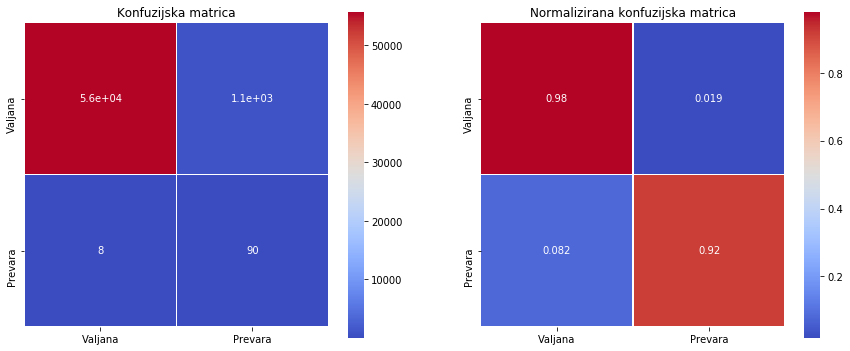

----------------------------------------------------------------------------------------------------


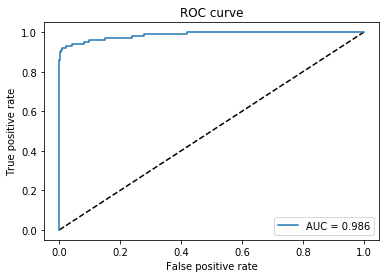

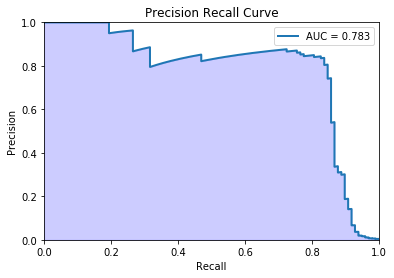

----------------------------------------------------------------------------------------------------
Glasački klasifikator (2)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.3999999999999995%
	Recall score: 91.84%
	F1 score: 13.69%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.92      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


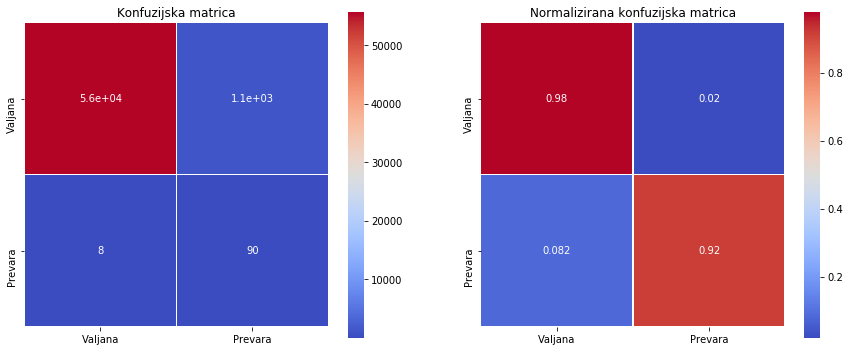

----------------------------------------------------------------------------------------------------


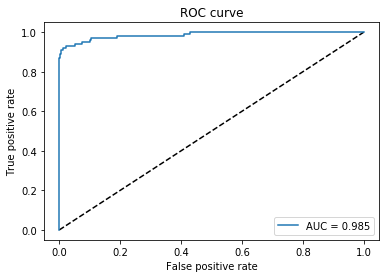

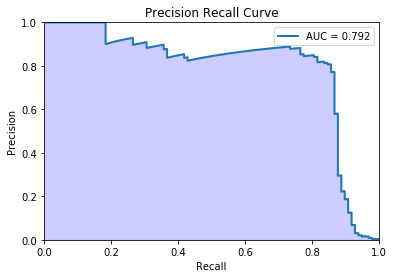

----------------------------------------------------------------------------------------------------
Glasački klasifikator (3)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.41%
	Recall score: 91.84%
	F1 score: 13.719999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.92      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


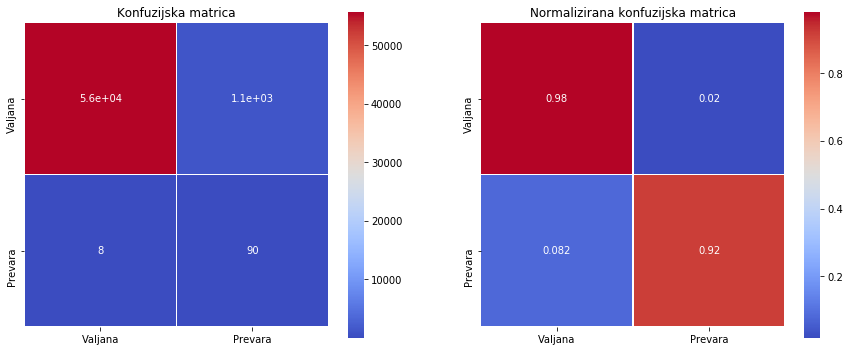

----------------------------------------------------------------------------------------------------


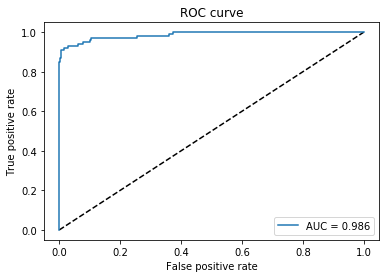

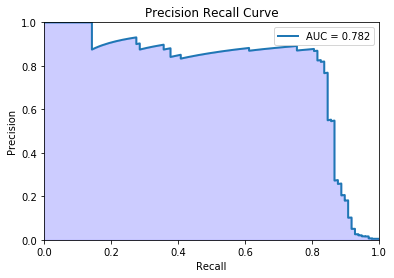

----------------------------------------------------------------------------------------------------
Glasački klasifikator (4)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.739999999999999%
	Recall score: 92.86%
	F1 score: 14.299999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.93      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


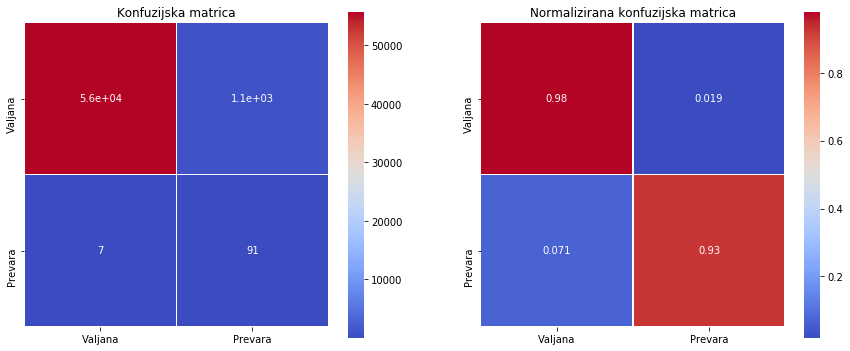

----------------------------------------------------------------------------------------------------


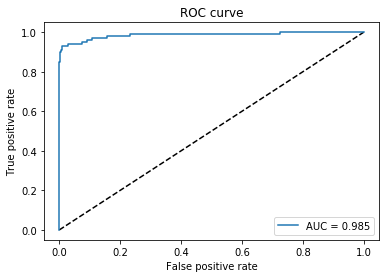

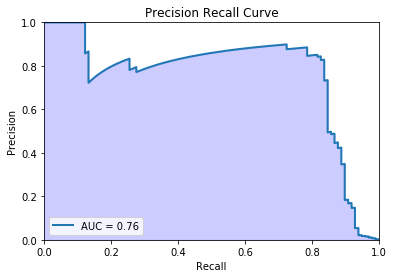

****************************************************************************************************


In [70]:
full_pred_voting1_params = voting1_usample.predict(X_data_test)
full_score_voting1_params = voting1_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting2_params = voting2_usample.predict(X_data_test)
full_score_voting2_params = voting2_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting3_params = voting3_usample.predict(X_data_test)
full_score_voting3_params = voting3_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting4_params = voting4_usample.predict(X_data_test)
full_score_voting4_params = voting4_usample.predict_proba(X_data_test)[:, 1]

print('*'*100)
print('Glasački klasifikator (1)')
print_everything(y_data_test, full_pred_voting1_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting1_params, True)
print('-'*100)
print("Glasački klasifikator (2)")
print_everything(y_data_test, full_pred_voting2_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting2_params, True)
print('-'*100)
print("Glasački klasifikator (3)")
print_everything(y_data_test, full_pred_voting3_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting3_params, True)
print('-'*100)
print("Glasački klasifikator (4)")
print_everything(y_data_test, full_pred_voting4_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting4_params, True)
print('*'*100)

Komentari za prva 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Prvi glasački klasifikator (1)</em> - solidan klasifikator sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 8.58%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 15.68%</li>
            <li><i>ispravno klasificirane prevare</i>: 89</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~950</li>
        </ul>
    </li>
    <li><em>Drugi glasački klasifikator (2)</em> - dosta bolji od prvog klasifikatora sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 12.81%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 22.45%</li>
            <li><i>ispravno klasificirane prevare</i>: 89 (jednako kao i prvi)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~610 (~340 manje od prvog)</li>
        </ul>
    </li>
    <li><em>Treći glasački klasifikator (3)</em> - klasifikator u rangu prvog (očito lošiji od drugog) sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 10.6%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 18.97%</li>
            <li><i>ispravno klasificirane prevare</i>: 88 (jedna manje nego prethodna 2)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~740 (za ~210 bolje od prvog)</li>
        </ul>
    </li>
    <li><em>Četvrti glasački klasifikator (4)</em> - dosad drugi najbolji klasifikator (bolji od (1) i (3)) sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 8.71%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 15.89%</li>
            <li><i>ispravno klasificirane prevare</i>: 89</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~930 (~20 manje od prvog)</li>
        </ul>
    </li>
</ul>

****************************************************************************************************
Glasački klasifikator (5)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.460000000000001%
	Recall score: 93.88%
	F1 score: 12.08%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.94      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


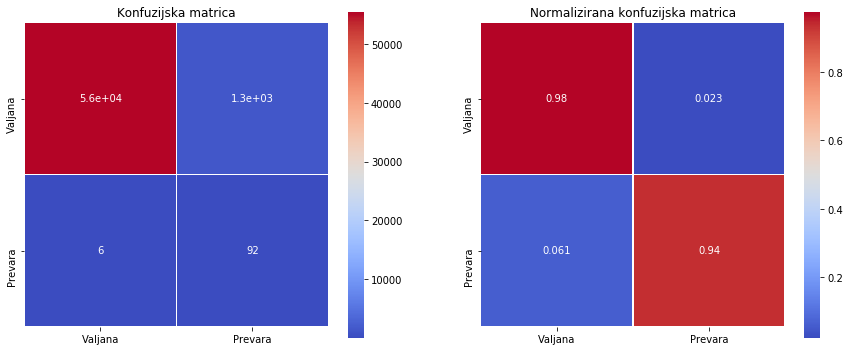

----------------------------------------------------------------------------------------------------


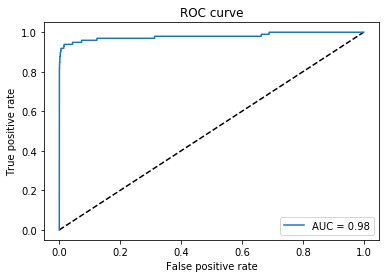

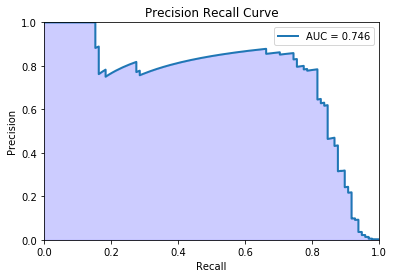

----------------------------------------------------------------------------------------------------
Glasački klasifikator (6)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.17%
	Recall score: 89.8%
	F1 score: 6.12%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


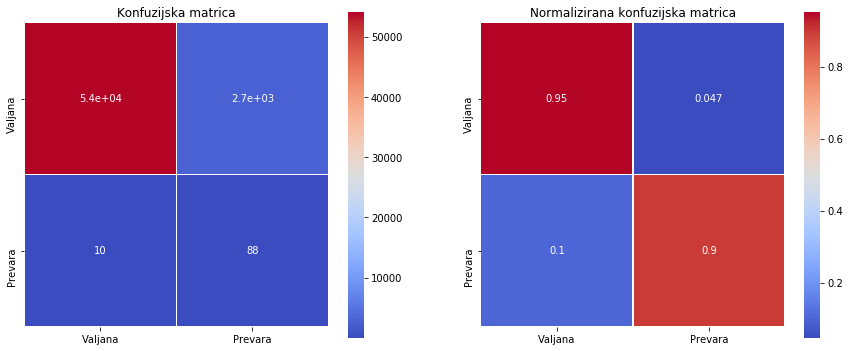

----------------------------------------------------------------------------------------------------


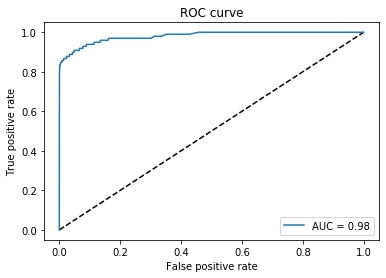

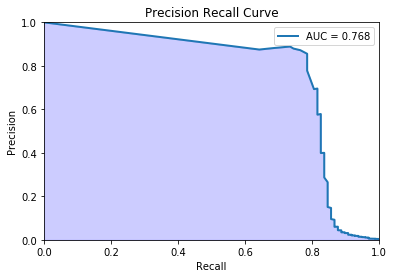

----------------------------------------------------------------------------------------------------
Glasački klasifikator (7)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.34%
	Recall score: 90.82000000000001%
	F1 score: 11.85%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


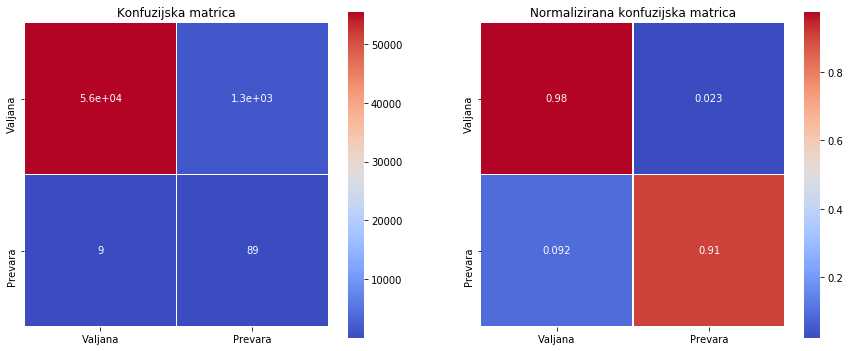

----------------------------------------------------------------------------------------------------


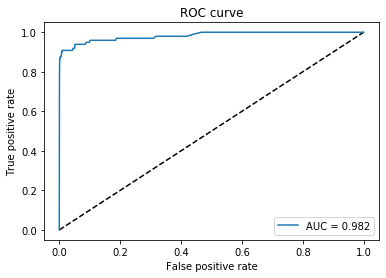

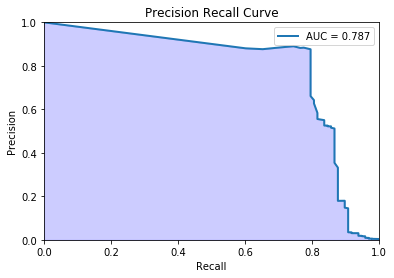

----------------------------------------------------------------------------------------------------
Glasački klasifikator (8)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.33%
	Recall score: 90.82000000000001%
	F1 score: 15.27%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


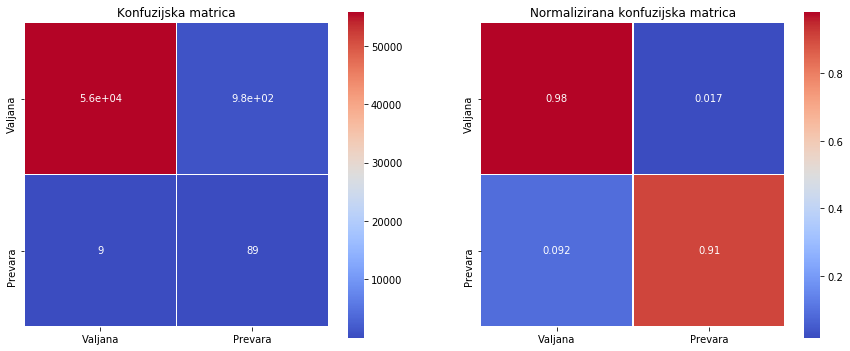

----------------------------------------------------------------------------------------------------


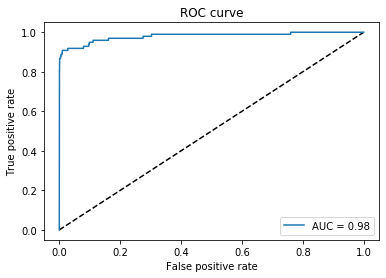

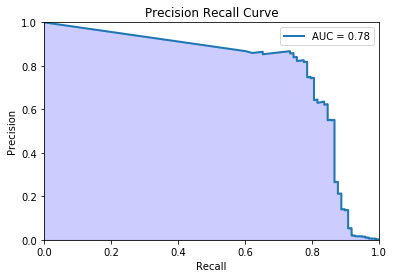

****************************************************************************************************


In [71]:
full_pred_voting5_params = voting5_usample.predict(X_data_test)
full_score_voting5_params = voting5_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting6_params = voting6_usample.predict(X_data_test)
full_score_voting6_params = voting6_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting7_params = voting7_usample.predict(X_data_test)
full_score_voting7_params = voting7_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting8_params = voting8_usample.predict(X_data_test)
full_score_voting8_params = voting8_usample.predict_proba(X_data_test)[:, 1]

print('*'*100)
print('Glasački klasifikator (5)')
print_everything(y_data_test, full_pred_voting5_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting5_params, True)
print('-'*100)
print("Glasački klasifikator (6)")
print_everything(y_data_test, full_pred_voting6_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting6_params, True)
print('-'*100)
print("Glasački klasifikator (7)")
print_everything(y_data_test, full_pred_voting7_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting7_params, True)
print('-'*100)
print("Glasački klasifikator (8)")
print_everything(y_data_test, full_pred_voting8_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting8_params, True)
print('*'*100)

Komentari za druga 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Peti glasački klasifikator (5)</em> - vrlo dobar klasifikator (malo lošiji od (2), ali bolji od ostalih):
        <ul>
            <li><i>preciznost</i>: 13.17%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 22.98%</li>
            <li><i>ispravno klasificirane prevare</i>: 88</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~580</li>
        </ul>
    </li>
    <li><em>Šesti glasački klasifikator (6)</em> - također vrlo dobar klasifikator (u rangu s prethodnim):
        <ul>
            <li><i>preciznost</i>: 14.45%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 24.93%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (najmanje od svih dosad)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~510 (također najmanje dosad)</li>
        </ul>
    </li>
    <li><em>Sedmi glasački klasifikator (7)</em> - ovo je već fantastičan klasifikator sa značajnije boljim rezultatima od prethodnog:
        <ul>
            <li><i>preciznost</i>: 22.19%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 35.51%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (jednako kao i prethodni)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~300 (za ~210 bolje od prethodnog)</li>
        </ul>
    </li>
    <li><em>Osmi glasački klasifikator (8)</em> - ovaj klasifikator je čak i malo bolji od prethodnog
        <ul>
            <li><i>preciznost</i>: 22.48% (0.29% bolje od prethodnog)</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 35.88% (0.37% bolje od prethodnog)</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (jednako kao i prethodni)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~300 </li>
        </ul>
    </li>
</ul>

****************************************************************************************************
Glasački klasifikator (9)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.43%
	Recall score: 91.84%
	F1 score: 15.440000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.92      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


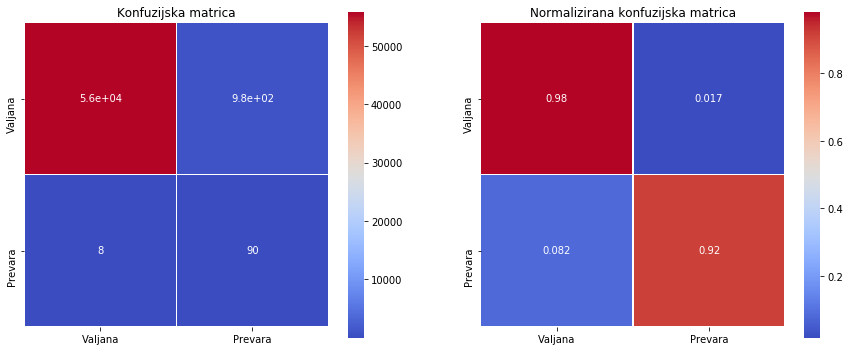

----------------------------------------------------------------------------------------------------


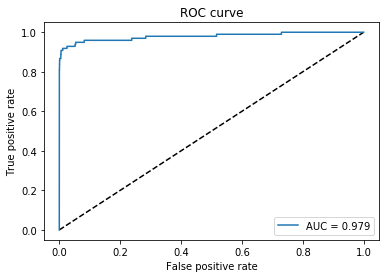

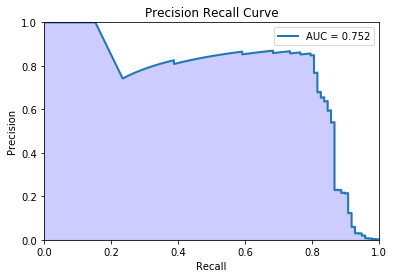

----------------------------------------------------------------------------------------------------
Glasački klasifikator (10)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.799999999999999%
	Recall score: 90.82000000000001%
	F1 score: 16.05%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


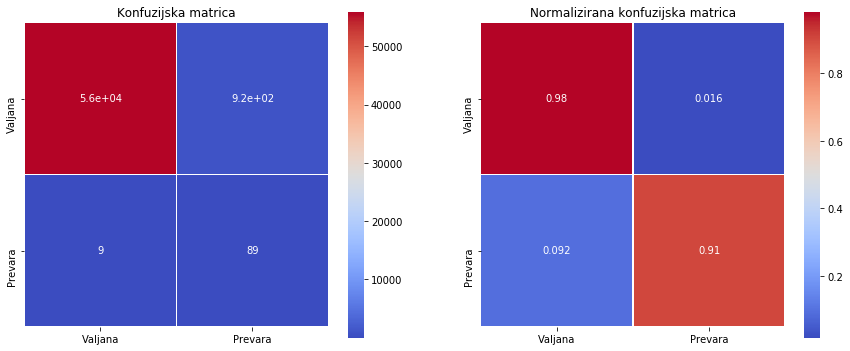

----------------------------------------------------------------------------------------------------


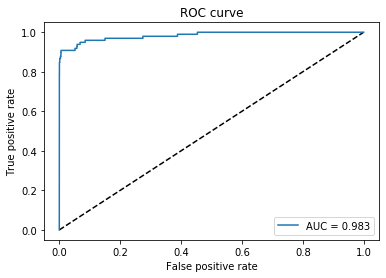

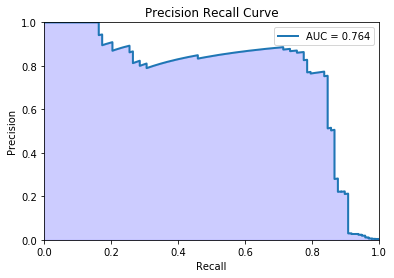

----------------------------------------------------------------------------------------------------
Glasački klasifikator (11)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.99%
	Recall score: 93.88%
	F1 score: 11.27%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.94      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


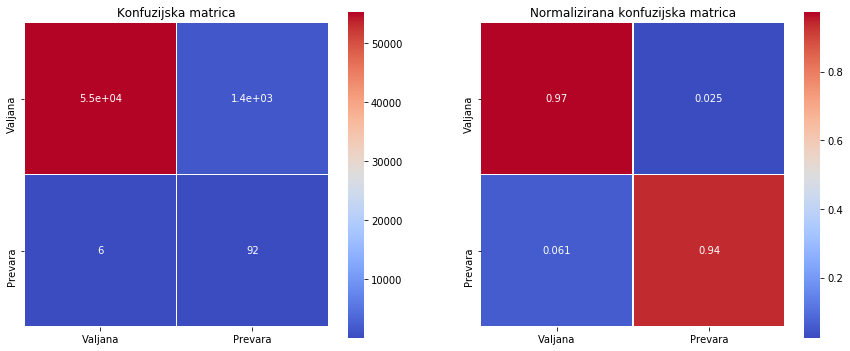

----------------------------------------------------------------------------------------------------


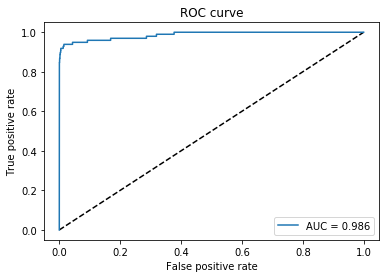

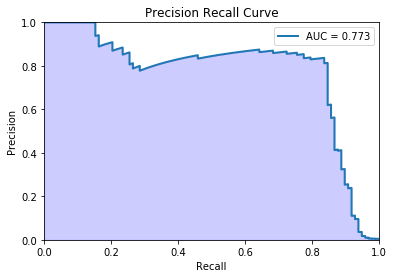

****************************************************************************************************


In [72]:
full_pred_voting9_params = voting9_usample.predict(X_data_test)
full_score_voting9_params = voting9_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting10_params = voting10_usample.predict(X_data_test)
full_score_voting10_params = voting10_usample.predict_proba(X_data_test)[:, 1]

full_pred_voting11_params = voting11_usample.predict(X_data_test)
full_score_voting11_params = voting11_usample.predict_proba(X_data_test)[:, 1]

print('*'*100)
print('Glasački klasifikator (9)')
print_everything(y_data_test, full_pred_voting9_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting9_params, True)
print('-'*100)
print("Glasački klasifikator (10)")
print_everything(y_data_test, full_pred_voting10_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting10_params, True)
print('-'*100)
print("Glasački klasifikator (11)")
print_everything(y_data_test, full_pred_voting11_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_voting11_params, True)
print('*'*100)

Komentari za prva 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Deveti glasački klasifikator (9)</em> - poprilično dobar klasifikator sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 12.14%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 21.39%</li>
            <li><i>ispravno klasificirane prevare</i>: 88</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~640</li>
        </ul>
    </li>
    <li><em>Deseti glasački klasifikator (10)</em> - jedan od slabijih klasifikatora (u usporedbi sa ostalim glasačkim, i dalje nije loš):
        <ul>
            <li><i>preciznost</i>: 12.63%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 22.11%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 </li>
            <li><i>pogrešno klasificiryne valjane</i>: ~600 </li>
        </ul>
    </li>
    <li><em>Jedanaesti glasački klasifikator (11)</em> - klasifikator sa boljim prepoznavanjem prevara (najbolji od zadnja 3):
        <ul>
            <li><i>preciznost</i>: 11.37%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 20.2%</li>
            <li><i>ispravno klasificirane prevare</i>: 89 (jedan od boljih glasačkih)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~690 </li>
        </ul>
    </li>

</ul>

## Near miss

In [ ]:
#opis nearmissa

In [73]:
from imblearn.under_sampling import NearMiss

In [74]:
nearmiss1 = NearMiss(version=1)
nearmiss2 = NearMiss(version=2)
nearmiss3 = NearMiss(version=3)

X_nm1_train, y_nm1_train = nearmiss1.fit_resample(X_data_train, y_data_train)
y_nm1_non_fraud_num = y_nm1_train.value_counts()[0]
y_nm1_fraud_num = y_nm1_train.value_counts()[1]

X_nm2_train, y_nm2_train = nearmiss2.fit_resample(X_data_train, y_data_train)
y_nm2_non_fraud_num = y_nm2_train.value_counts()[0]
y_nm2_fraud_num = y_nm2_train.value_counts()[1]

X_nm3_train, y_nm3_train = nearmiss3.fit_resample(X_data_train, y_data_train)
y_nm3_non_fraud_num = y_nm3_train.value_counts()[0]
y_nm3_fraud_num = y_nm3_train.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss1): ' + str(y_nm1_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss1): ' + str(y_nm1_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss1): ' + str(y_nm1_fraud_num + y_nm1_non_fraud_num))
print('-'*100)

print('Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss2): ' + str(y_nm2_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss2): ' + str(y_nm2_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss2): ' + str(y_nm2_fraud_num + y_nm2_non_fraud_num))
print('-'*100)

print('Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss3): ' + str(y_nm3_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss3): ' + str(y_nm3_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss3): ' + str(y_nm3_fraud_num + y_nm3_non_fraud_num))
print('-'*100)

Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss1): 394
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss1): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss1): 788
----------------------------------------------------------------------------------------------------
Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss2): 394
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss2): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss2): 788
----------------------------------------------------------------------------------------------------
Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss3): 327
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss3): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss3): 721
---------------------------------------------------------------------

C:\Users\stvar\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


### Logistička regresija

In [75]:
nm1_log_reg = LogisticRegression(solver='liblinear')
nm1_log_reg.fit(X_nm1_train, y_nm1_train)

nm1_log_reg_training_score = cross_val_score(nm1_log_reg, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss1): ' 
     + str(round(nm1_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss1): 94.96%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.44999999999999996%
	Recall score: 92.86%
	F1 score: 0.89%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.64      0.78     56864
           1       0.00      0.93      0.01        98

    accuracy                           0.65     56962
   macro avg       0.50      0.79      0.40     56962
weighted avg       1.00      0.65      0.78     56962


----------------------------------------------------------------------------------------------------


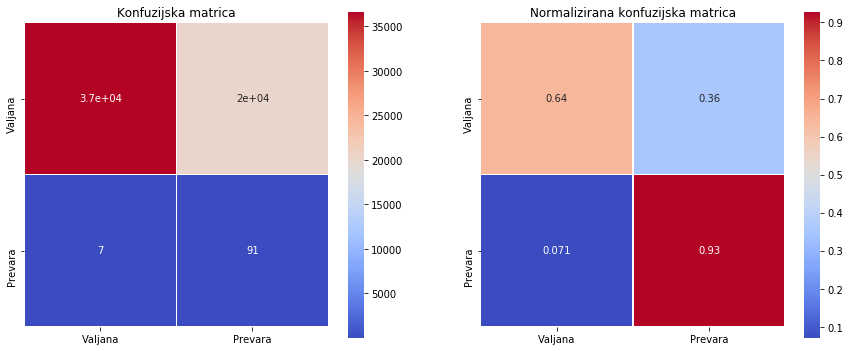

----------------------------------------------------------------------------------------------------


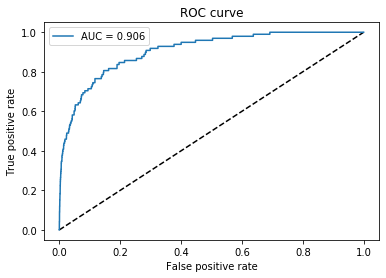

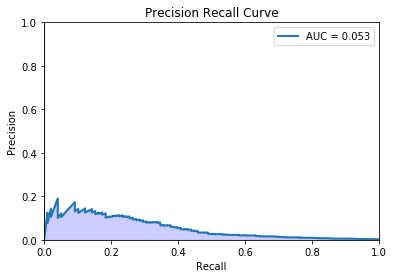

In [76]:
full_pred_log_reg_nm1 = nm1_log_reg.predict(X_data_test)
full_pred_score_log_reg_nm1 = nm1_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_nm1, True)

In [77]:
nm2_log_reg = LogisticRegression(solver='liblinear')
nm2_log_reg.fit(X_nm2_train, y_nm2_train)

nm2_log_reg_training_score = cross_val_score(nm2_log_reg, X_nm2_train, y_nm2_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss2): ' 
     + str(round(nm2_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss2): 89.72%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.29%
	Recall score: 87.76%
	F1 score: 0.58%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.48      0.65     56864
           1       0.00      0.88      0.01        98

    accuracy                           0.48     56962
   macro avg       0.50      0.68      0.33     56962
weighted avg       1.00      0.48      0.65     56962


----------------------------------------------------------------------------------------------------


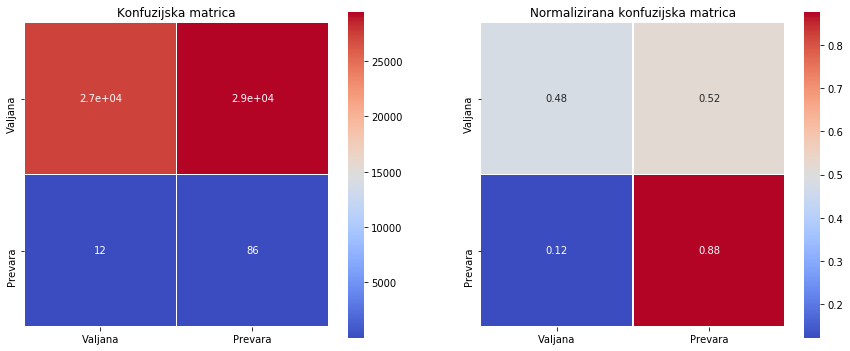

----------------------------------------------------------------------------------------------------


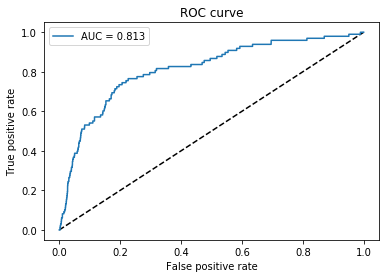

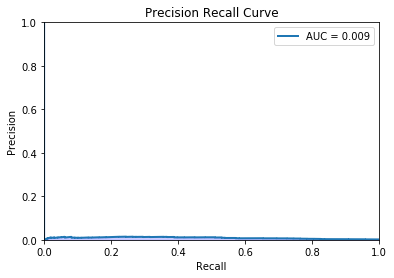

In [78]:
full_pred_log_reg_nm2 = nm2_log_reg.predict(X_data_test)
full_pred_score_log_reg_nm2 = nm2_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_nm2, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_nm2, True)

In [79]:
nm3_log_reg = LogisticRegression(solver='liblinear')
nm3_log_reg.fit(X_nm3_train, y_nm3_train)

nm3_log_reg_training_score = cross_val_score(nm3_log_reg, X_nm3_train, y_nm3_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss3): ' 
     + str(round(nm3_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss3): 76.47%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.05%
	Recall score: 74.49%
	F1 score: 2.06%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56864
           1       0.01      0.74      0.02        98

    accuracy                           0.88     56962
   macro avg       0.50      0.81      0.48     56962
weighted avg       1.00      0.88      0.93     56962


----------------------------------------------------------------------------------------------------


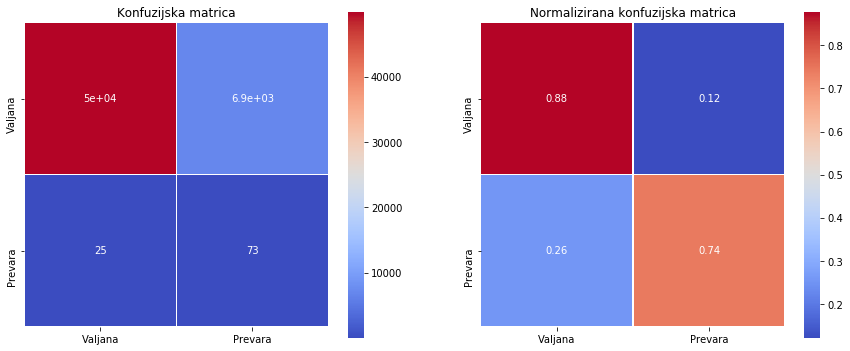

----------------------------------------------------------------------------------------------------


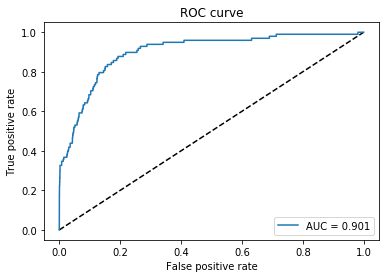

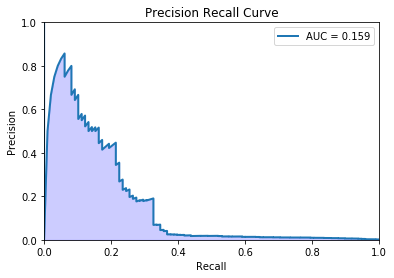

In [80]:
full_pred_log_reg_nm3 = nm3_log_reg.predict(X_data_test)
full_pred_score_log_reg_nm3 = nm3_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_nm3, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_nm3, True)

Rezultati koje smo dobili bilo kojom od 3 NearMiss verzija su poprilično loši.<br>
Za verziju 1 model je dobro klasificirao čak 91 prevaru, ali također je i pogrešno klasificirao čak ~20 000 valjanih transakcija. Osjetljivost je zavidnih 92.86%, dok su i preciznost i f1-mjera manje od 1%. <br>
Verzija 2 je još gora jer su i preciznost i f1-mjera i osjetljivost manje nego kod prve verzije. Ovaj model je ispravno klasificirao 86 prevara dok je pogrešno klasificirano čak ~29 000 valjanih transakcija (više je pogrešno klasificiranih valjanih transakcija nego ispravno klasificiranih !!!). <br>
Treća verzija NearMiss algoritma je također sramotna. Preciznost je ~1%, f1-mjera 2%, dok je osjetljivost mizernih 74.49%. Odnosno, taj model je ispravno klasificirao svega 73 prevare, dok je pogrešno klasificirao ~6900 valjanih transkcija. <br>
Pokušat ćemo podesiti parametre u nadi da će se ti rezultati popraviti.

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


NearMiss1:
Najbolji parametri: {'C': 10, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss1) datasetom (sa parametrima): 95.00999999999999%
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.41000000000000003%
	Recall score: 92.86%
	F1 score: 0.8200000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     56864
           1       0.00      0.93      0.01        98

    accuracy                           0.61     56962
   macro avg       0.50      0.77      0.38     56962
weighted avg       1.00      0.61      0.76     56962


----------------------------------------------------------------------------------------------------


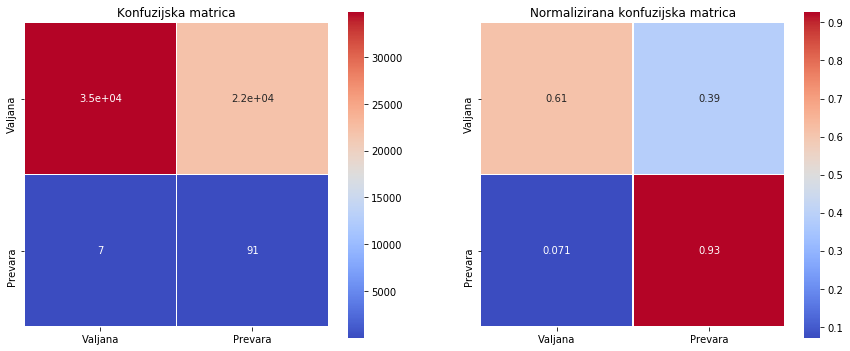

----------------------------------------------------------------------------------------------------


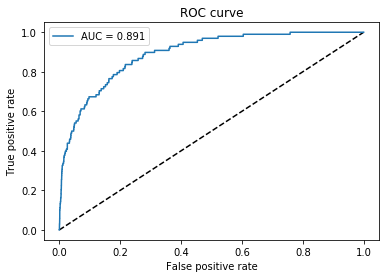

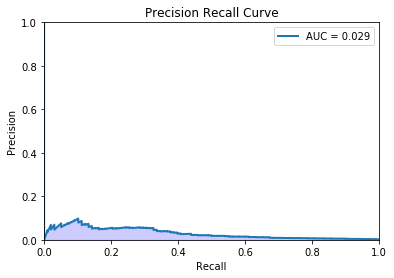

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NearMiss2:
Najbolji parametri: {'C': 0.01, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss2) datasetom (sa parametrima): 92.17%
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.31%
	Recall score: 91.84%
	F1 score: 0.62%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.49      0.66     56864
           1       0.00      0.92      0.01        98

    accuracy                           0.49     56962
   macro avg       0.50      0.70      0.33     56962
weighted avg       1.00      0.49      0.66     56962


--

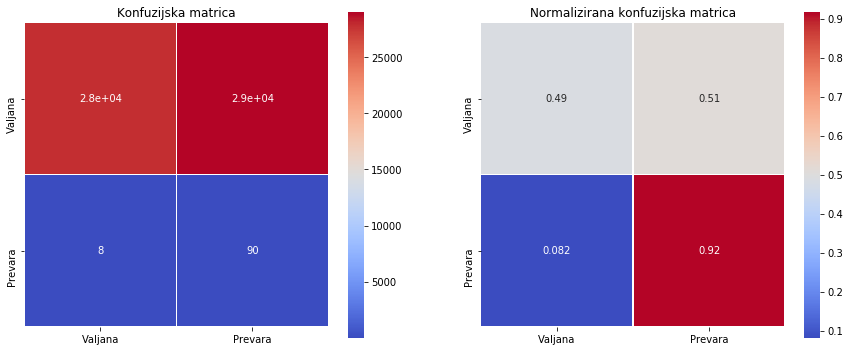

----------------------------------------------------------------------------------------------------


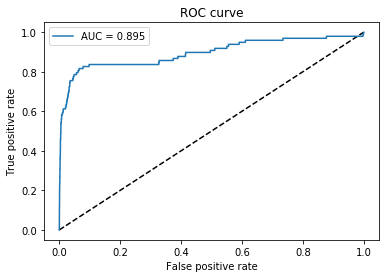

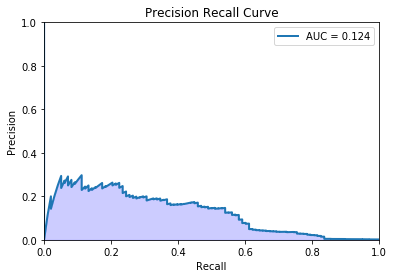

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NearMiss3:
Najbolji parametri: {'C': 0.1, 'penalty': 'l1'}
Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss3) datasetom (sa parametrima): 78.97%
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.4%
	Recall score: 80.61%
	F1 score: 4.66%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.02      0.81      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.87      0.51     56962
weighted avg       1.00      0.94      0.97     56962


----

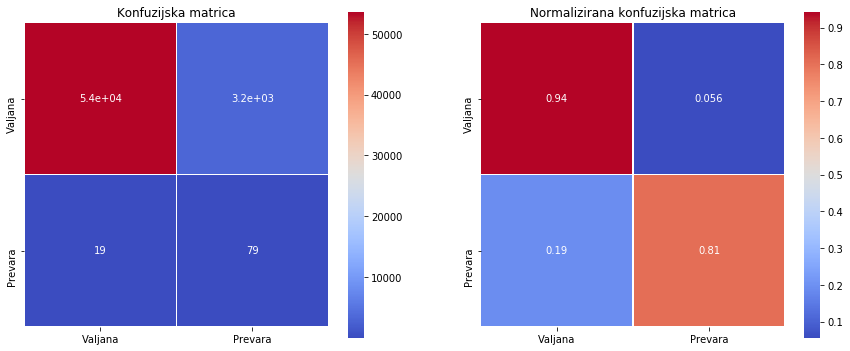

----------------------------------------------------------------------------------------------------


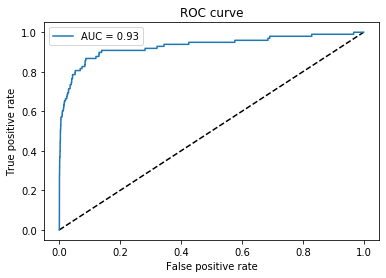

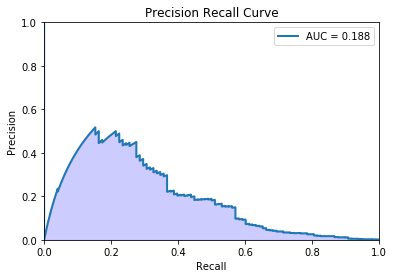

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [98]:
grid_log_reg_nm1 = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_nm1.fit(X_nm1_train, y_nm1_train)
log_reg_est_nm1 = grid_log_reg_nm1.best_estimator_
log_reg_params_nm1 = grid_log_reg_nm1.best_params_

print('NearMiss1:')
print('Najbolji parametri: ' + str(log_reg_params_nm1))

log_reg_training_score_params_nm1 = cross_val_score(log_reg_est_nm1, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss1) datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_nm1.mean(), 4) * 100) + '%')

full_pred_log_reg_params_nm1 = log_reg_est_nm1.predict(X_data_test)
full_pred_score_log_reg_params_nm1 = log_reg_est_nm1.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_nm1, True)
print('+'*100)
print('+'*100)

grid_log_reg_nm2 = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_nm2.fit(X_nm2_train, y_nm2_train)
log_reg_est_nm2 = grid_log_reg_nm2.best_estimator_
log_reg_params_nm2 = grid_log_reg_nm2.best_params_

print('NearMiss2:')
print('Najbolji parametri: ' + str(log_reg_params_nm2))

log_reg_training_score_params_nm2 = cross_val_score(log_reg_est_nm2, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss2) datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_nm2.mean(), 4) * 100) + '%')

full_pred_log_reg_params_nm2 = log_reg_est_nm2.predict(X_data_test)
full_pred_score_log_reg_params_nm2 = log_reg_est_nm2.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_nm2, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_nm2, True)
print('+'*100)
print('+'*100)

grid_log_reg_nm3 = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_nm3.fit(X_nm3_train, y_nm3_train)
log_reg_est_nm3 = grid_log_reg_nm3.best_estimator_
log_reg_params_nm3 = grid_log_reg_nm3.best_params_

print('NearMiss3:')
print('Najbolji parametri: ' + str(log_reg_params_nm3))

log_reg_training_score_params_nm3 = cross_val_score(log_reg_est_nm3, X_nm3_train, y_nm3_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss3) datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_nm3.mean(), 4) * 100) + '%')

full_pred_log_reg_params_nm3 = log_reg_est_nm3.predict(X_data_test)
full_pred_score_log_reg_params_nm3 = log_reg_est_nm3.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_nm3, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_nm3, True)
print('+'*100)
print('+'*100)

Rezultati su se blago poboljšali za drugu i treću verziju NearMissa, ali su i dalje katastrofalni. Moguće je da NearMiss ne funkcionira dobro sa Logističkom regresijom pa ćemo probati na još metodi najbližih susjeda. 

### Metoda najbližih susjeda

In [99]:
nm1_knn = KNeighborsClassifier()
nm1_knn.fit(X_nm1_train, y_nm1_train)

nm1_knn_training_score = cross_val_score(nm1_knn, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za metodu najbližih susjeda nad undersampliranim datasetom (NearMiss1): ' 
     + str(round(nm1_knn_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu najbližih susjeda nad undersampliranim datasetom (NearMiss1): 94.5%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.73%
	Recall score: 90.82000000000001%
	F1 score: 1.44%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     56864
           1       0.01      0.91      0.01        98

    accuracy                           0.79     56962
   macro avg       0.50      0.85      0.45     56962
weighted avg       1.00      0.79      0.88     56962


----------------------------------------------------------------------------------------------------


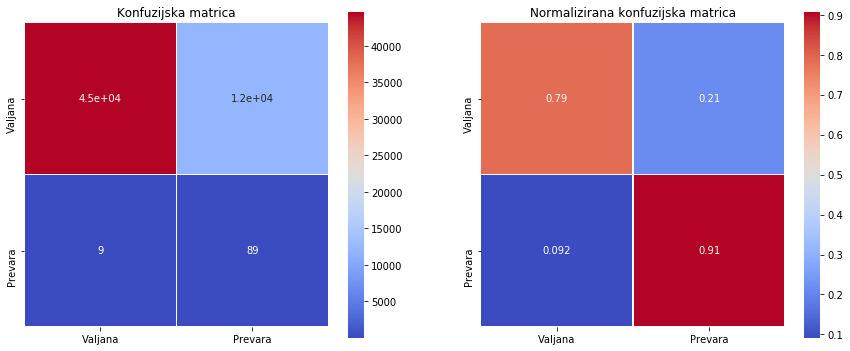

----------------------------------------------------------------------------------------------------


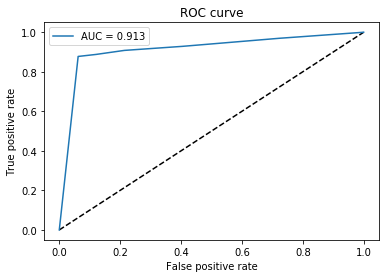

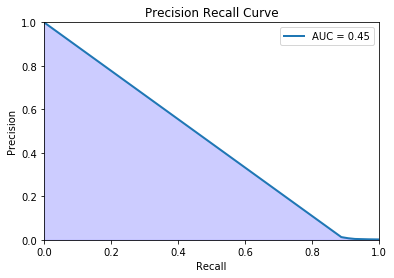

In [101]:
full_pred_knn_nm1= nm1_knn.predict(X_data_test)
full_score_knn_nm1 = nm1_knn.predict_proba(X_data_test)[:, 1]

print_everything(y_data_test, full_pred_knn_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_knn_nm1, True)

Rezultati za metodu najbližih susjeda su nešto bolji, no i dalje je broj pogrešno klasificiranih valjanih transakcija prevelik (~12 000). Koristili smo samo prvu verziju NearMissa jer je kod logističke regresije pokazala najbolje rezultate.

In [21]:
num_neighbors_params = [1, 2, 3, 4, 5, 7, 9]
alg_params = ['auto', 'brute', 'ball_tree', 'kd_tree']
p_params = [1, 2]

knn_params = {'n_neighbors': num_neighbors_params, 'algorithm': alg_params, 'p': p_params, 'metric': ['minkowski']}

In [102]:
grid_knn_nm1 = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn_nm1.fit(X_nm1_train, y_nm1_train)
knn_nm1_est = grid_knn_nm1.best_estimator_
knn_params_nm1 = grid_knn_nm1.best_params_
print('Najbolji parametri: ' + str(knn_params_nm1))

knn_training_score_params_nm1 = cross_val_score(knn_nm1_est, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za k (' +  str(knn_params_nm1['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim (NearMiss1) datasetom (sa parametrima): ' 
     + str(round(knn_training_score_params_nm1.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 3, 'p': 2}
Rezultat treniranja za k (3)  najbližih susjeda nad undersampliranim (NearMiss1) datasetom (sa parametrima): 94.71000000000001%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.51%
	Recall score: 92.86%
	F1 score: 1.01%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     56864
           1       0.01      0.93      0.01        98

    accuracy                           0.69     56962
   macro avg       0.50      0.81      0.41     56962
weighted avg       1.00      0.69      0.81     56962


----------------------------------------------------------------------------------------------------


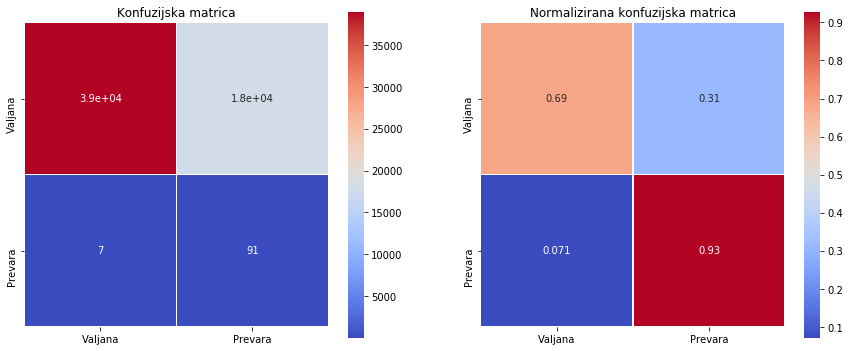

----------------------------------------------------------------------------------------------------


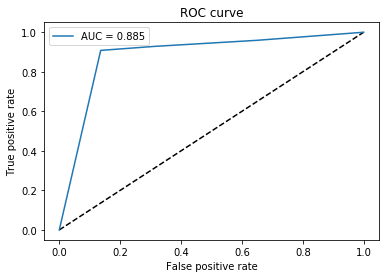

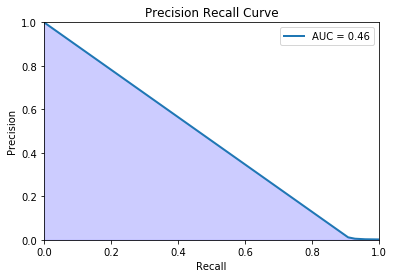

In [103]:
full_pred_knn_nm1_params = knn_nm1_est.predict(X_data_test)
full_score_knn_nm1_params = knn_nm1_est.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_knn_nm1_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_knn_nm1_params, True)

Nakon podešavanja parametara broj pogrešno valjanih transakcija je još porastao (~18 000), dobro je jedino što smo bar dobili veći broj ispravno klasificiranih prevara.

### XGB

Još ćemo pokušati iskoristiti XGB kao klasifikator (obzirom da je bio jako dobar na nasumičnom undersamplingu).

In [104]:
nm1_xgb = XGBClassifier()
nm1_xgb.fit(X_nm1_train, y_nm1_train)

nm1_xgb_training_score = cross_val_score(nm1_xgb, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za XGB nad undersampliranim datasetom (NearMiss1): ' 
     + str(round(nm1_xgb_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za XGB nad undersampliranim datasetom (NearMiss1): 95.69%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.22999999999999998%
	Recall score: 97.96000000000001%
	F1 score: 0.44999999999999996%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.26      0.41     56864
           1       0.00      0.98      0.00        98

    accuracy                           0.26     56962
   macro avg       0.50      0.62      0.21     56962
weighted avg       1.00      0.26      0.41     56962


----------------------------------------------------------------------------------------------------


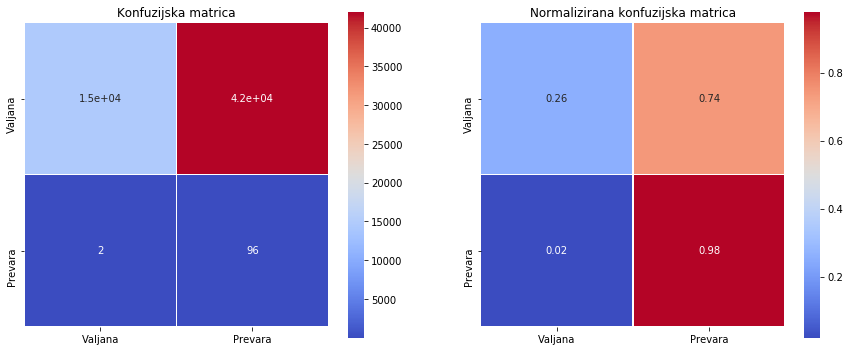

----------------------------------------------------------------------------------------------------


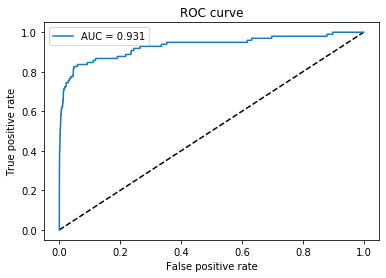

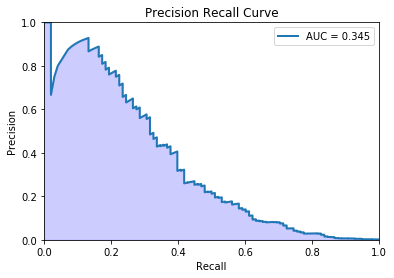

In [105]:
full_pred_xgb_nm1 = nm1_xgb.predict(X_data_test)
full_score_xgb_nm1 = nm1_xgb.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_xgb_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_xgb_nm1, True)

Korištenjem NearMissa kao undersampling metode i XGB-a kao klasifikatora rezultati su također vrlo loši. Iako imamo rekordnih 96 ispravno klasificiranih prevara, imamo i rekord u broj pogrešno klasificiranih valjanih transakcija (~42 000 ili 74%). 

In [8]:
xgb_gamma = [0, 1, 5, 10]
xgb_max_depth = [1, 2, 3, 4, 5, 7]
xgb_colsample_bytree = [0.3, 0.5, 0.8]
xgb_learning_rate = [0.3, 0.1, 0.05, 0.01]
xgb_n_estimators = [10, 20, 50, 100]
xgb_params = {'gamma': xgb_gamma, 'max_depth': xgb_max_depth, 'colsample_bytree': xgb_colsample_bytree, 
              'learning_rate': xgb_learning_rate, 'n_estimators': xgb_n_estimators}

In [106]:
grid_xgb_nm1 = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb_nm1.fit(X_nm1_train, y_nm1_train)
xgb_nm1_est = grid_xgb_nm1.best_estimator_
xgb_params_nm1 = grid_xgb_nm1.best_params_
print('Najbolji parametri: ' + str(xgb_params_nm1))

xgb_training_score_params_nm1 = cross_val_score(xgb_nm1_est, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za XGB nad undersampliranim (NearMiss1) datasetom (sa parametrima): ' 
     + str(round(xgb_training_score_params_nm1.mean(), 4) * 100) + '%')

Najbolji parametri: {'colsample_bytree': 0.3, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 20}
Rezultat treniranja za XGB nad undersampliranim (NearMiss1) datasetom (sa parametrima): 96.49%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.22%
	Recall score: 96.94%
	F1 score: 0.44%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.24      0.39     56864
           1       0.00      0.97      0.00        98

    accuracy                           0.24     56962
   macro avg       0.50      0.60      0.20     56962
weighted avg       1.00      0.24      0.39     56962


----------------------------------------------------------------------------------------------------


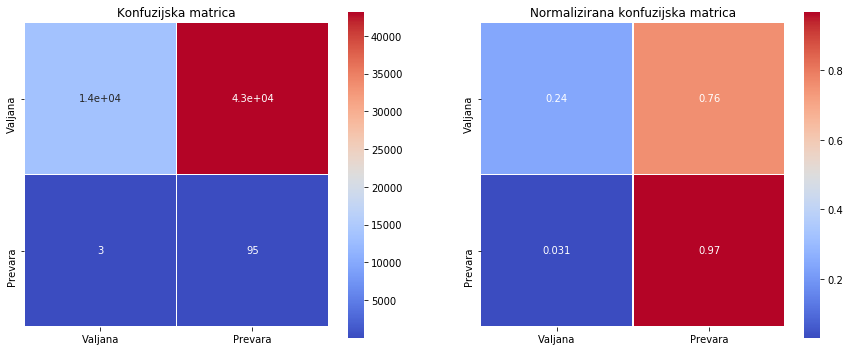

----------------------------------------------------------------------------------------------------


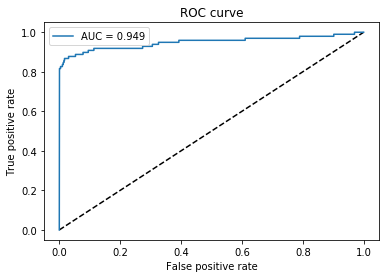

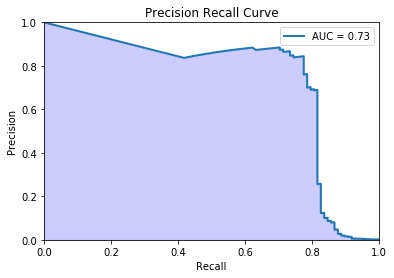

In [107]:
full_pred_xgb_nm1_params = xgb_nm1_est.predict(X_data_test)
full_score_xgb_nm1_params = xgb_nm1_est.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_xgb_nm1_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_xgb_nm1_params, True)

Podešavanjem parametara smo ustvari dobili još lošije rezultate.

## Stisnuti najbliži susjedi

In [ ]:
# from imblearn.under_sampling import CondensedNearestNeighbour

# cnn = CondensedNearestNeighbour()

# X_cnn_train, y_cnn_train = cnn.fit_resample(X_data_train, y_data_train)
# y_cnn_non_fraud_num = y_cnn_train.value_counts()[0]
# y_cnn_fraud_num = y_cnn_train.value_counts()[1]


# print('Broj valjanih transakcija u trening skupu nakon undersamplinga (CondensedNearestNeighbour): ' + str(y_cnn_non_fraud_num))
# print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (CondensedNearestNeighbour): ' + str(y_cnn_fraud_num))
# print('Ukupan broj transakcija u trening skupu nakon undersamplinga (CondensedNearestNeighbour): ' + str(y_cnn_fraud_num + y_cnn_non_fraud_num))

### Logistička regresija

In [ ]:
# cnn_log_reg = LogisticRegression(solver='liblinear')
# cnn_log_reg.fit(X_cnn_train, y_cnn_train)

# cnn_log_reg_training_score = cross_val_score(cnn_log_reg, X_cnn_train, y_cnn_train, cv=rskf)
# print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (CondensedNearestNeighbour): ' 
#      + str(round(cnn_log_reg_training_score.mean(), 4) * 100) + '%')

In [ ]:
# full_pred_log_reg_cnn = cnn_log_reg.predict(X_data_test)
# full_pred_score_log_reg_cnn = cnn_log_reg.decision_function(X_data_test)
# print_everything(y_data_test, full_pred_log_reg_cnn, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_cnn, True)

In [ ]:
#komentari

### Slučajne šume

In [ ]:
# cnn_rf = RandomForestClassifier()
# cnn_rf.fit(X_cnn_train, y_cnn_train)

# cnn_rf_training_score = cross_val_score(cnn_rf, X_cnn_train, y_cnn_train, cv=rskf)
# print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (CondensedNearestNeighbour): ' 
#      + str(round(cnn_rf_training_score.mean(), 4) * 100) + '%')

In [ ]:
# full_pred_rf_cnn = cnn_rf.predict(X_data_test)
# print_everything(y_data_test, full_pred_rf_cnn, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

In [ ]:
#komentari

## Jednostrana selekcija

In [4]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection()

X_oss_train, y_oss_train = oss.fit_resample(X_data_train, y_data_train)
y_oss_non_fraud_num = y_oss_train.value_counts()[0]
y_oss_fraud_num = y_oss_train.value_counts()[1]


print('Broj valjanih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): ' + str(y_oss_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): ' + str(y_oss_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (OneSidedSelection): ' + str(y_oss_fraud_num + y_oss_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): 214873
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (OneSidedSelection): 215267


### Bagging Classifier

In [23]:
oss_bag = BaggingClassifier()
oss_bag.fit(X_oss_train, y_oss_train)

oss_bag_training_score = cross_val_score(oss_bag, X_oss_train, y_oss_train, cv=rskf)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (OneSidedSelection): ' 
     + str(round(oss_bag_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (OneSidedSelection): 99.94%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 97.39999999999999%
	Recall score: 76.53%
	F1 score: 85.71%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


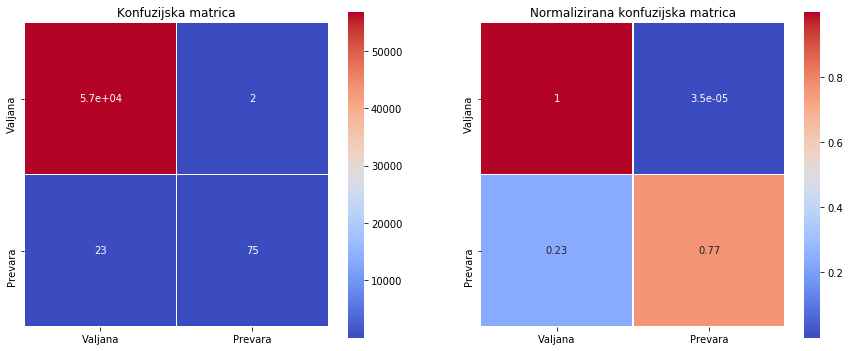

----------------------------------------------------------------------------------------------------


In [24]:
full_pred_bag_oss = oss_bag.predict(X_data_test)
print_everything(y_data_test, full_pred_bag_oss, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Vidimo da sa bagging klasifikatorom dobijamo jako visoku preciznost (97.4%) i f1-mjeru (85.71%), dok je osjetljivost dosta niža nego što bismo željeli (76.53%). Iz konfuzijske matrice vidimo da su samo 2 (ukupno ih je oko 57 000) valjane transakcije klasificirane kao prevare, dok je čak 23 prevare klasificirano kao valjane transakcije (od ukupno 98 prevara). 

### Metoda potpornih vektora

In [5]:
oss_svc = SVC()
oss_svc.fit(X_oss_train, y_oss_train)

oss_svc_training_score = cross_val_score(oss_svc, X_oss_train, y_oss_train, cv=rskf)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (OneSidedSelection): ' 
     + str(round(oss_svc_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (OneSidedSelection): 99.92999999999999%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 96.83%
	Recall score: 62.239999999999995%
	F1 score: 75.78%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.62      0.76        98

    accuracy                           1.00     56962
   macro avg       0.98      0.81      0.88     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


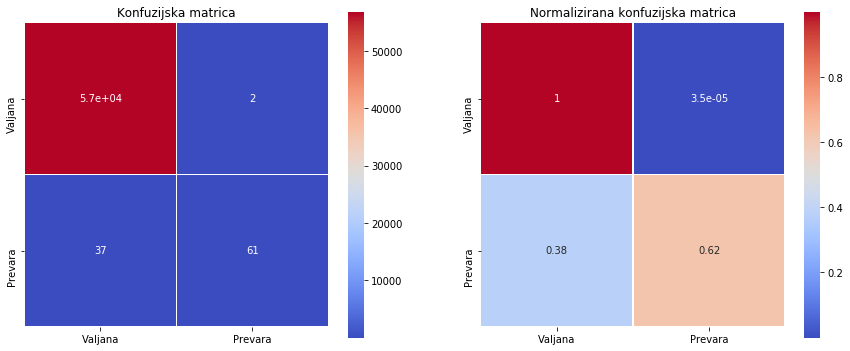

----------------------------------------------------------------------------------------------------


In [6]:
full_pred_svc_oss = oss_svc.predict(X_data_test)
print_everything(y_data_test, full_pred_svc_oss, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Korištenjem metode potpornih vektora dobili smo prilično loše rezultate. Iako je preciznost visoka (96.83%), osjetljivost (62.24%) i f1-mjera (75.78%) su slabije. Odnosno, gledajući matricu konfuzije vidimo da su samo 2 valjane transakcije klasificirane kao prevare, dok je čak 37 prevara (od ukupno 98) klasificirano kao valjane transakcije. Valjalo bi napomenuti da nismo podešavali nikakve parametre. Također ako promotrimo malo bolje možemo vidjeti da klasifikator postiže jednake rezultate kao i klasifikator treniran na originalnom trening skupu podataka.

### XGB

In [7]:
oss_xgb = XGBClassifier()
oss_xgb.fit(X_oss_train, y_oss_train)

oss_xgb_training_score = cross_val_score(oss_xgb, X_oss_train, y_oss_train, cv=rskf)
print('Rezultat treniranja za XGB nad undersampliranim datasetom (OneSidedSelection): ' 
     + str(round(oss_xgb_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za XGB nad undersampliranim datasetom (OneSidedSelection): 99.95%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 93.02%
	Recall score: 81.63%
	F1 score: 86.96000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


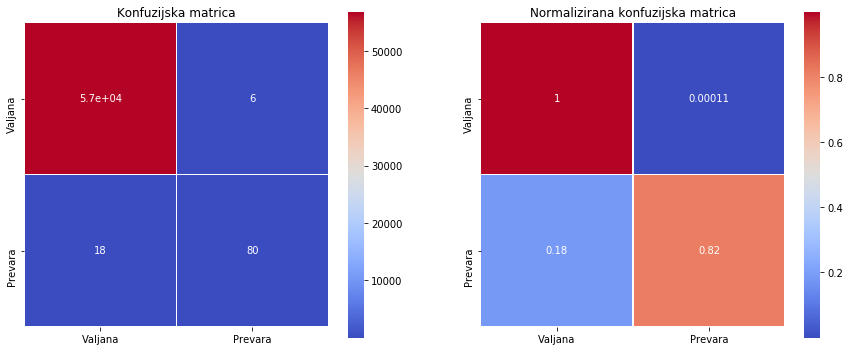

----------------------------------------------------------------------------------------------------


In [9]:
full_pred_xgb_oss = oss_xgb.predict(X_data_test)
print_everything(y_data_test, full_pred_xgb_oss, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

I u ovom slučaju undersampling nije omogućio bolje rezultate, ali jest vjerojatno ubrzao postupak treniranja.

## Pravilo čišćenja susjedstva

In [4]:
# from imblearn.under_sampling import NeighbourhoodCleaningRule
# ncr = NeighbourhoodCleaningRule()

# X_ncr_train, y_ncr_train = ncr.fit_resample(X_data_train, y_data_train)
# y_ncr_non_fraud_num = y_ncr_train.value_counts()[0]
# y_ncr_fraud_num = y_ncr_train.value_counts()[1]


# print('Broj valjanih transakcija u trening skupu nakon undersamplinga (NeighbourhoodCleaningRule): ' + str(y_ncr_non_fraud_num))
# print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NeighbourhoodCleaningRule): ' + str(y_ncr_fraud_num))
# print('Ukupan broj transakcija u trening skupu nakon undersamplinga (NeighbourhoodCleaningRule): ' + str(y_ncr_fraud_num + y_ncr_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon undersamplinga (NeighbourhoodCleaningRule): 227198
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NeighbourhoodCleaningRule): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (NeighbourhoodCleaningRule): 227592


### Slučajne šume

In [8]:
ncr_rf = RandomForestClassifier()
ncr_rf.fit(X_ncr_train, y_ncr_train)

ncr_rf_training_score = cross_val_score(ncr_rf, X_ncr_train, y_ncr_train, cv=rskf)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (NeighbourhoodCleaningRule): ' 
     + str(round(ncr_rf_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za slučajne šume nad undersampliranim datasetom (NeighbourhoodCleaningRule): 99.96000000000001%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 90.8%
	Recall score: 80.61%
	F1 score: 85.41%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


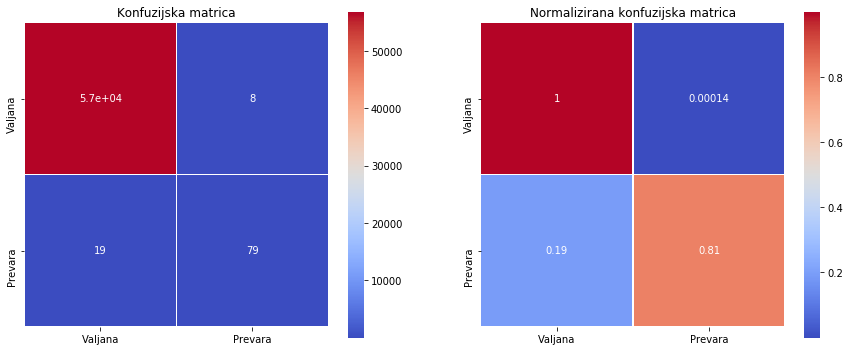

----------------------------------------------------------------------------------------------------


In [9]:
full_pred_rf_ncr = ncr_rf.predict(X_data_test)
print_everything(y_data_test, full_pred_rf_ncr, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

In [5]:
#komentari

### LGBM

In [10]:
ncr_lgbm = LGBMClassifier()
ncr_lgbm.fit(X_ncr_train, y_ncr_train)

ncr_lgbm_training_score = cross_val_score(ncr_lgbm, X_ncr_train, y_ncr_train, cv=rskf)
print('Rezultat treniranja za LGBM nad undersampliranim datasetom (NeighbourhoodCleaningRule): ' 
     + str(round(ncr_lgbm_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za LGBM nad undersampliranim datasetom (NeighbourhoodCleaningRule): 99.53%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 24.82%
	Recall score: 34.69%
	F1 score: 28.939999999999998%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.35      0.29        98

    accuracy                           1.00     56962
   macro avg       0.62      0.67      0.64     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


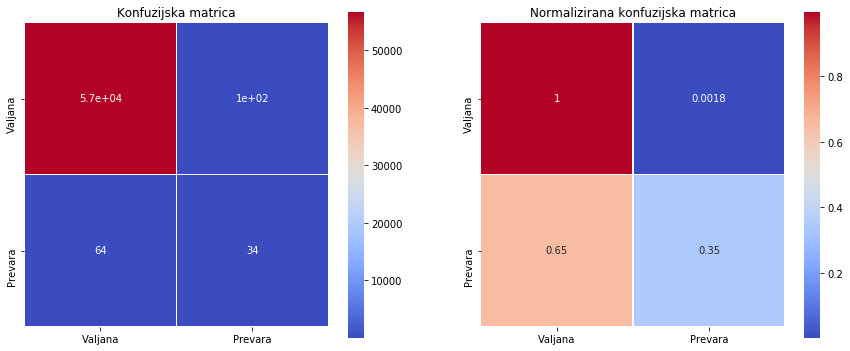

----------------------------------------------------------------------------------------------------


In [12]:
full_pred_lgbm_ncr = ncr_lgbm.predict(X_data_test)
print_everything(y_data_test, full_pred_lgbm_ncr, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

In [ ]:
#komentari

## Odbacivanje outliera

Sljedeće ćemo pronaći ekstremne outliere i izbrisati ih. Time se nadamo da ćemo maknuti pristranost koju ti outlieri nose. Zato trebamo naći koje značajke najviše pridonose klasi koja će biti pridjeljena nekoj transakciji, odnosno trebamo naći značajke kod kojih je najveća pozitivna ili negativna korelacija. Koristimo podatke dobivene nasumičnim undersamplingom (jer je to bila najbolja undersampling metoda).

In [108]:
usample_train = X_usample_train
usample_train['Class'] = y_usample_train

In [109]:
print('Negativne korelacije: ' + str(np.where(usample_train.corr()['Class'] < -0.6))) 
print('Pozitivne korelacije: ' + str(np.where(usample_train.corr()['Class'] > 0.6)))    

Negativne korelacije: (array([10, 12, 14], dtype=int64),)
Pozitivne korelacije: (array([ 4, 11, 29], dtype=int64),)


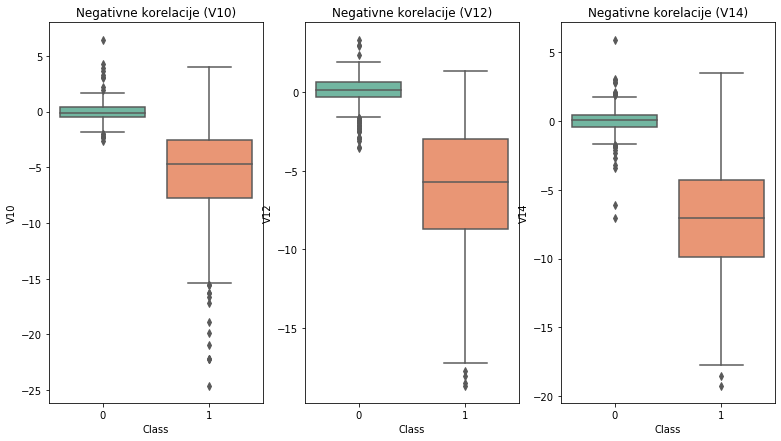

In [110]:
fig_neg, ax_neg = plt.subplots(1, 3, figsize=(13,7))
ax_neg[0].set_title('Negativne korelacije (V10)')
ax_neg[1].set_title('Negativne korelacije (V12)')
ax_neg[2].set_title('Negativne korelacije (V14)')
sns.boxplot(x='Class', y='V10', data=usample_train, ax=ax_neg[0], palette='Set2')
sns.boxplot(x='Class', y='V12', data=usample_train, ax=ax_neg[1], palette='Set2')
sns.boxplot(x='Class', y='V14', data=usample_train, ax=ax_neg[2], palette='Set2')
plt.show()


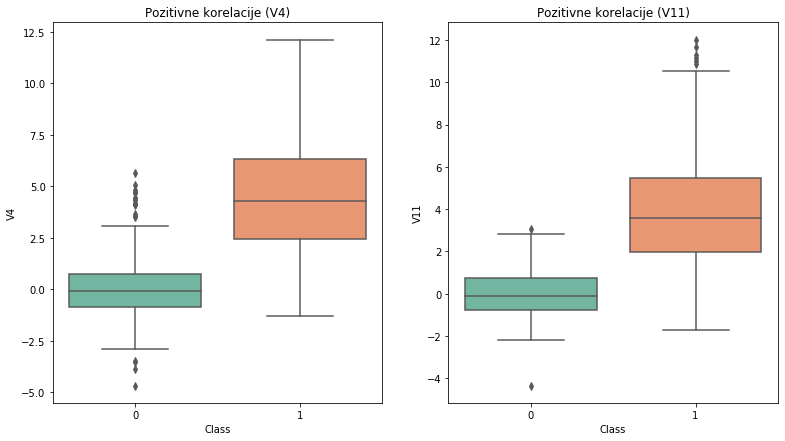

In [111]:
fig_pos, ax_pos = plt.subplots(1, 2, figsize=(13,7))
ax_pos[0].set_title('Pozitivne korelacije (V4)')
ax_pos[1].set_title('Pozitivne korelacije (V11)')
sns.boxplot(x='Class', y='V4', data=usample_train, ax=ax_pos[0], palette='Set2')
sns.boxplot(x='Class', y='V11', data=usample_train, ax=ax_pos[1], palette='Set2')
plt.show()

<b>Napomena</b>: Primjetimo da je posljednja pozitivna značajka (29) ustvari značajka 'Class' koja je sigurno korelirana sama sa sobom pa nju ne koristimo za izbacivanje outliera.

In [112]:
#uklanjanje outliera (za negativnu korelaciju)
v10_q1 = usample_train['V10'].quantile(0.25)
v10_q3 = usample_train['V10'].quantile(0.75)
v10_q2 = v10_q3 - v10_q1
v10_cut_off = v10_q2 * 1.5
v10_lower, v10_upper = v10_q1 - v10_cut_off, v10_q3 + v10_cut_off
v10_outliers = [out for out in usample_train['V10'] if out < v10_lower or out > v10_upper]
print('-' * 50)
print('Broj identificiranih outliera nad V10: ' + str(len(v10_outliers)))

v12_q1 = usample_train['V12'].quantile(0.25)
v12_q3 = usample_train['V12'].quantile(0.75)
v12_q2 = v12_q3 - v12_q1
v12_cut_off = v12_q2 * 1.5
v12_lower, v12_upper = v12_q1 - v12_cut_off, v12_q3 + v12_cut_off
v12_outliers = [out for out in usample_train['V12'] if out < v12_lower or out > v12_upper]
print('Broj identificiranih outliera nad V12: ' + str(len(v12_outliers)))

v14_q1 = usample_train['V14'].quantile(0.25)
v14_q3 = usample_train['V14'].quantile(0.75)
v14_q2 = v14_q3 - v14_q1
v14_cut_off = v14_q2 * 1.5
v14_lower, v14_upper = v14_q1 - v14_cut_off, v14_q3 + v14_cut_off
v14_outliers = [out for out in usample_train['V14'] if out < v14_lower or out > v14_upper]
print('Broj identificiranih outliera nad V14: ' + str(len(v14_outliers)))
print('-' * 50)

--------------------------------------------------
Broj identificiranih outliera nad V10: 57
Broj identificiranih outliera nad V12: 28
Broj identificiranih outliera nad V14: 2
--------------------------------------------------


In [113]:
#uklanjanje outliera (za pozitivne korelaciju)
v4_q1 = usample_train['V4'].quantile(0.25)
v4_q3 = usample_train['V4'].quantile(0.75)
v4_q2 = v4_q3 - v4_q1
v4_cut_off = v4_q2 * 1.5
v4_lower, v4_upper = v4_q1 - v4_cut_off, v4_q3 + v4_cut_off
v4_outliers = [out for out in usample_train['V4'] if out < v4_lower or out > v4_upper]
print('-' * 50)
print('Broj identificiranih outliera nad V4: ' + str(len(v4_outliers)))

v11_q1 = usample_train['V11'].quantile(0.25)
v11_q3 = usample_train['V11'].quantile(0.75)
v11_q2 = v11_q3 - v11_q1
v11_cut_off = v11_q2 * 1.5
v11_lower, v11_upper = v11_q1 - v11_cut_off, v11_q3 + v11_cut_off
v11_outliers = [out for out in usample_train['V11'] if out < v11_lower or out > v11_upper]
print('Broj identificiranih outliera nad V11: ' + str(len(v11_outliers)))
print('-' * 50)

--------------------------------------------------
Broj identificiranih outliera nad V4: 8
Broj identificiranih outliera nad V11: 15
--------------------------------------------------


In [114]:
usample_train_cut = usample_train.drop(
    usample_train[
        (usample_train['V10'] > v10_upper) | 
        (usample_train['V10'] < v10_lower) |
        (usample_train['V12'] > v12_upper) | 
        (usample_train['V12'] < v12_lower) |
        (usample_train['V14'] > v14_upper) | 
        (usample_train['V14'] < v14_lower) |
        (usample_train['V4'] > v4_upper) | 
        (usample_train['V4'] < v4_lower) |
        (usample_train['V11'] > v11_upper) | 
        (usample_train['V11'] < v11_lower) 
                     ].index)

In [115]:
X_usample_train_cut = usample_train_cut.drop('Class', axis=1)
y_usample_train_cut = usample_train_cut['Class']
y_cut_non_frauds = y_usample_train_cut.value_counts()[0]
y_cut_frauds = y_usample_train_cut.value_counts()[1]
print('Broj prevara u skupu za trening nakon izbacivanja outliera: ' + str(y_cut_frauds))
print('Broj valjanih transakcija u skupu za trening nakon izbacivanja outliera: ' + str(y_cut_non_frauds))
print('Ukupan broj transakcija korištenih za trening nakon izbacivanja outliera: ' + str(len(usample_train_cut)))

print('Postotak prevara u skupu za trening nakon izbacivanja outliera: ' + str(round(y_cut_frauds/len(usample_train_cut), 3) * 100) + '%')
print('Postotak valjanih transakcija u skupu za trening nakon izbacivanja outliera: ' + str(round(y_cut_non_frauds/len(usample_train_cut), 3) * 100) + '%')

Broj prevara u skupu za trening nakon izbacivanja outliera: 332
Broj valjanih transakcija u skupu za trening nakon izbacivanja outliera: 394
Ukupan broj transakcija korištenih za trening nakon izbacivanja outliera: 726
Postotak prevara u skupu za trening nakon izbacivanja outliera: 45.7%
Postotak valjanih transakcija u skupu za trening nakon izbacivanja outliera: 54.300000000000004%


Vidimo da je izbacivanjem outliera ostalo malo više valjanih transakcija nego prevara, no u originalnom skupu podataka ionako ima više valjanih transakcija. <br>
<b>Napomena</b>: Primjetimo da su ustvari jedino prevare izbačene iz trening skupa, odnosno prije izbacivanja outliera je bilo 394 prevare i 394 valjane transakcije (sve valjane su i dalje u skupu).

### Logistička regresija

In [116]:
grid_log_reg_cut = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_cut.fit(X_usample_train_cut, y_usample_train_cut)
log_reg_est_cut = grid_log_reg_cut.best_estimator_
log_reg_params_cut = grid_log_reg_cut.best_params_
print('Najbolji parametri: ' + str(log_reg_params_cut))

log_reg_training_score_params_usample_cut = cross_val_score(log_reg_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(log_reg_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 1, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 92.66%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.63%
	Recall score: 92.86%
	F1 score: 12.379999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


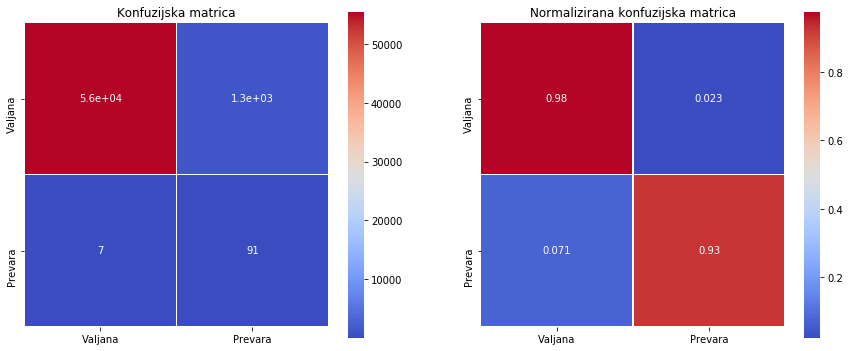

----------------------------------------------------------------------------------------------------


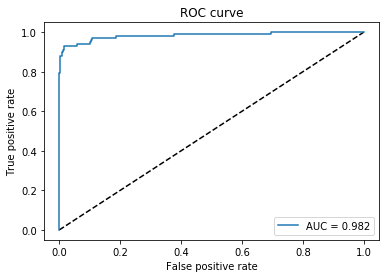

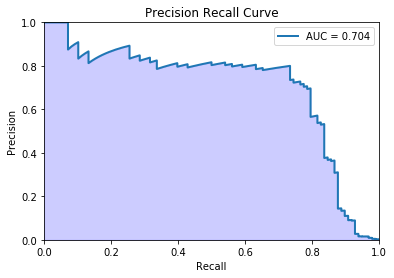

In [118]:
full_pred_log_reg_params_cut = log_reg_est_cut.predict(X_data_test)
full_pred_score_log_reg_params_cut = log_reg_est_cut.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_cut, True)

Nakon odbacivanja outliera dobivamo generalno nešto lošije rezultate nego prije odbacivanja. Vidimo da je osjetljivost viša (92.86%), dok su i preciznost (3.25%) i f1-mjera (6.28%) nešto niži. Odnosno, gledajući matricu konfuzije vidimo da je ovaj klasifikator pogrešno klasificirao čak ~2700 valjanih transakcija, ali je zato ispravno klasificirao čak 91 prevaru. Također, možemo primjetiti da je površina ispod PR-krivulje dosta manja.

### Stabla odluke

In [120]:
grid_dt_cut = GridSearchCV(DecisionTreeClassifier(), dt_params)
grid_dt_cut.fit(X_usample_train_cut, y_usample_train_cut)
dt_est_cut = grid_dt_cut.best_estimator_
dt_params_best_cut = grid_dt_cut.best_params_
print('Najbolji parametri: ' + str(dt_params_best_cut))

dt_training_score_params_usample_cut = cross_val_score(dt_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(dt_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'splitter': 'best'}
Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 91.64%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.77%
	Recall score: 87.76%
	F1 score: 5.37%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.88      0.05        98

    accuracy                           0.95     56962
   macro avg       0.51      0.91      0.51     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


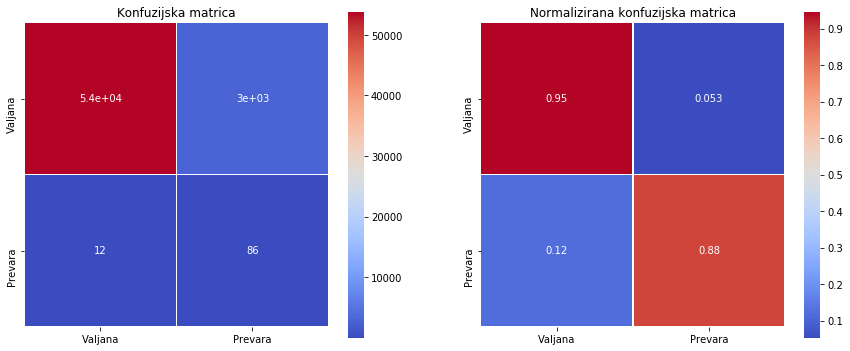

----------------------------------------------------------------------------------------------------


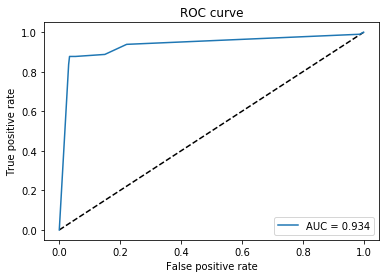

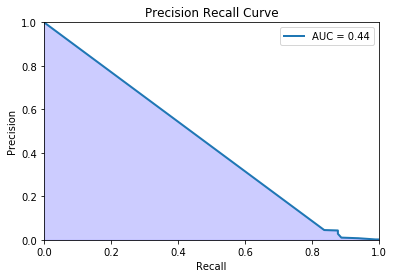

In [121]:
full_pred_dt_params_cut = dt_est_cut.predict(X_data_test)
full_score_dt_params_cut = dt_est_cut.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_dt_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_dt_params_cut, True)

Izbacivanjem outliera dobili smo nešto bolje rezultate za stabla odluke (u odnosu na prije odbacivanja). Odnosno, i preciznost (3.31%) i f1-mjera (6.38%) su više, dok je osjetljivost ostala ista (90.82%). Iz konfuzijske matrice vidimo da je sada pogrešno klasificirano ~2600 valjanih transakcija (bilo je ~4800), dok je ispravno klasificirano 89 prevara.

### Bagging 

In [122]:
grid_bag_cut = GridSearchCV(BaggingClassifier(), bag_params)
grid_bag_cut.fit(X_usample_train_cut, y_usample_train_cut)
bag_est_cut = grid_bag_cut.best_estimator_
bag_params_best_cut = grid_bag_cut.best_params_
print('Najbolji parametri: ' + str(bag_params_best_cut))

bag_training_score_params_usample_cut = cross_val_score(bag_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(bag_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'max_features': 0.5, 'max_samples': 0.9, 'n_estimators': 50}
Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 92.7%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.03%
	Recall score: 91.84%
	F1 score: 13.059999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.92      0.13        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


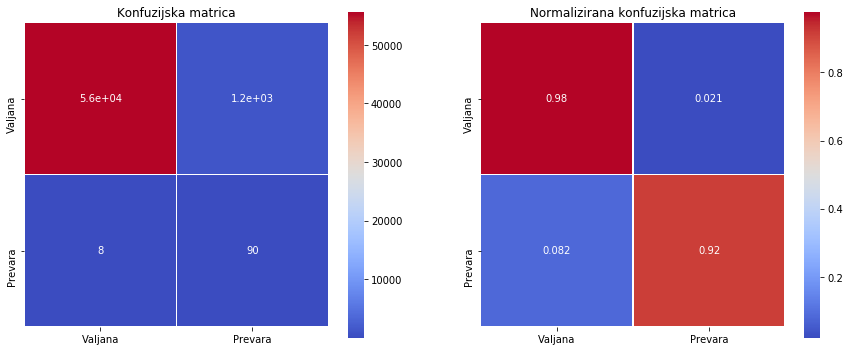

----------------------------------------------------------------------------------------------------


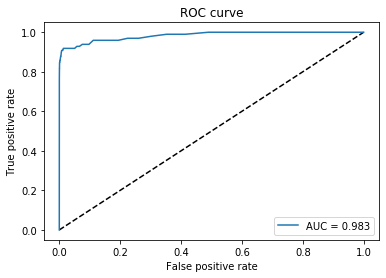

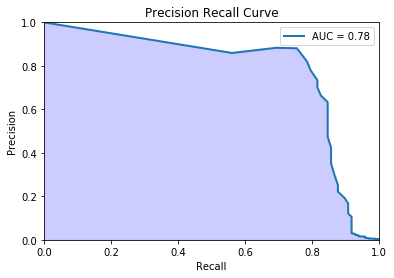

In [123]:
full_pred_bag_params_cut = bag_est_cut.predict(X_data_test)
full_score_bag_params_cut = bag_est_cut.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_bag_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_bag_params_cut, True)

Kod bagginga smo kao i kod logističke regresije dobili nešto nižu preciznost (5.41%), te f1-mjeru (10.22%), dok je osjetljivost nešto viša (92.86%). Iz konfuzijske matrice vidimo da je pogrešno klasificirano ~1600 valjanih transakcija (najmanje od svih klasifikatora nakon izbacivanja outliera dosad) te je ispravno klasificirano čak 91 prevara (najviše od svih klasifikatora nakon izbacivanja outliera dosad).

### Slučajne šume

In [124]:
grid_rf_cut = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf_cut.fit(X_usample_train_cut, y_usample_train_cut)
rf_est_cut = grid_rf_cut.best_estimator_
rf_params_best_cut = grid_rf_cut.best_params_
print('Najbolji parametri: ' + str(rf_params_best_cut))

rf_training_score_params_usample_cut = cross_val_score(rf_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(rf_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'n_estimators': 5}
Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 91.46%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.46%
	Recall score: 90.82000000000001%
	F1 score: 6.67%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.91      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


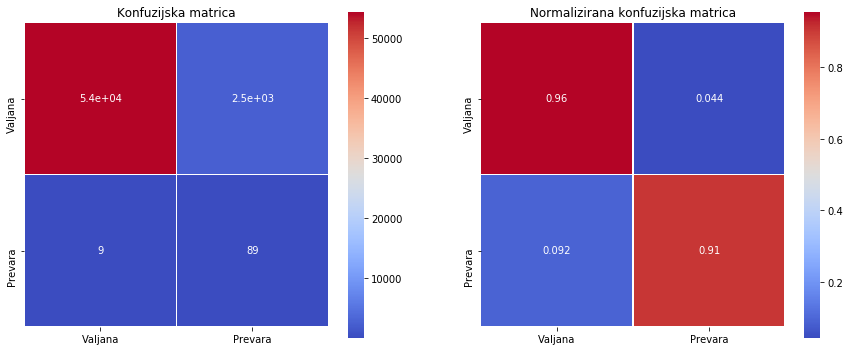

----------------------------------------------------------------------------------------------------


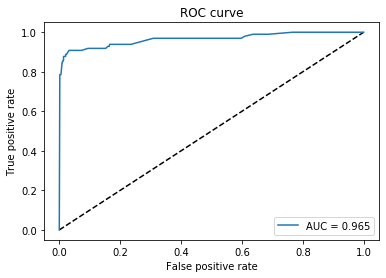

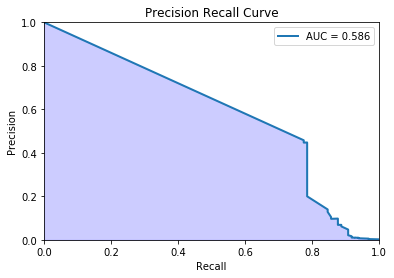

In [125]:
full_pred_rf_params_cut = rf_est_cut.predict(X_data_test)
full_score_rf_params_cut = rf_est_cut.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_rf_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_rf_params_cut, True)

Koristeći slučajne šume dobili smo slične rezultate kao i baggingom, no ipak su i preciznost (4.96%), i osjetljivost (91.84%) i f1-mjera (9.42%) niže. Iz matrice konfuzije viidmo da je ovaj klasifikator pogrešno klasificirao ~1700 valjanih transakcija (100 više od bagginga) te ispravno klasificirao 90 prevara (1 manje od bagginga).

### Metoda najbližih susjeda

In [126]:
grid_knn_cut = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn_cut.fit(X_usample_train_cut, y_usample_train_cut)
knn_est_cut = grid_knn_cut.best_estimator_
knn_params_best_cut = grid_knn_cut.best_params_
print('Najbolji parametri: ' + str(knn_params_best_cut))

knn_training_score_params_usample_cut = cross_val_score(knn_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za k (' +  str(knn_params_best_cut['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(knn_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
Rezultat treniranja za k (5)  najbližih susjeda nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 92.75%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.47%
	Recall score: 90.82000000000001%
	F1 score: 10.31%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


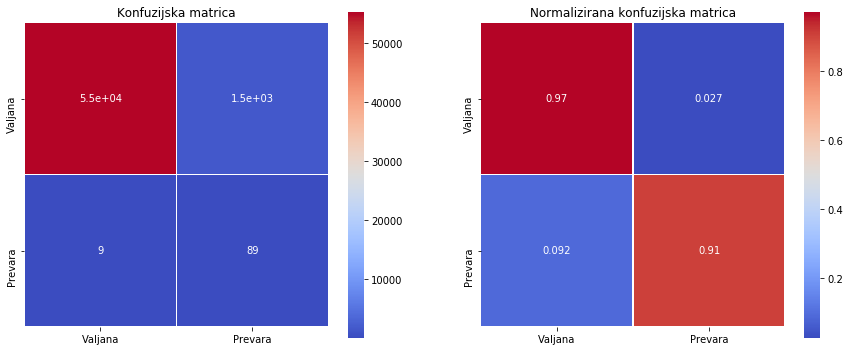

----------------------------------------------------------------------------------------------------


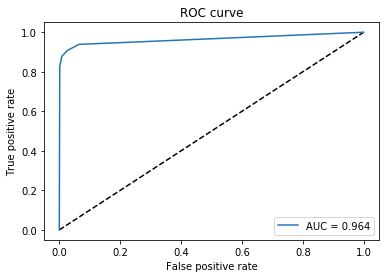

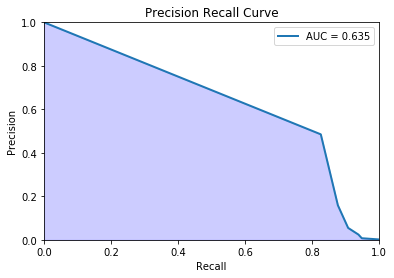

In [127]:
full_pred_knn_params_cut = knn_est_cut.predict(X_data_test)
full_score_knn_params_cut = knn_est_cut.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_knn_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_knn_params_cut, True)

I za metodu najbližih susjeda dobijamo slične rezultate. Sada je osjetljivost (90.82%) malo niža, ali su zasad i preciznost (5.57%) i f1-mjera (10.5%) najviši dosad. Odnosno, pogrešno je klasificirano ~1500 valjanih transakcija (~100 manje nego kod slučajnih šuma), dok je ispravno klasificirano 89 prevara (1 manje od slučajnih šuma).

### Metoda potpornih vektora

In [130]:
grid_svc_cut = GridSearchCV(SVC(probability=True), svc_params)
grid_svc_cut.fit(X_usample_train_cut, y_usample_train_cut)
svc_est_cut = grid_svc_cut.best_estimator_
svc_params_best_cut = grid_svc_cut.best_params_
print('Najbolji parametri: ' + str(svc_params_best_cut))

svc_training_score_params_usample_cut = cross_val_score(svc_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(svc_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.01, 'degree': 1, 'gamma': 10, 'kernel': 'poly'}
Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 92.47%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.450000000000001%
	Recall score: 89.8%
	F1 score: 15.45%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


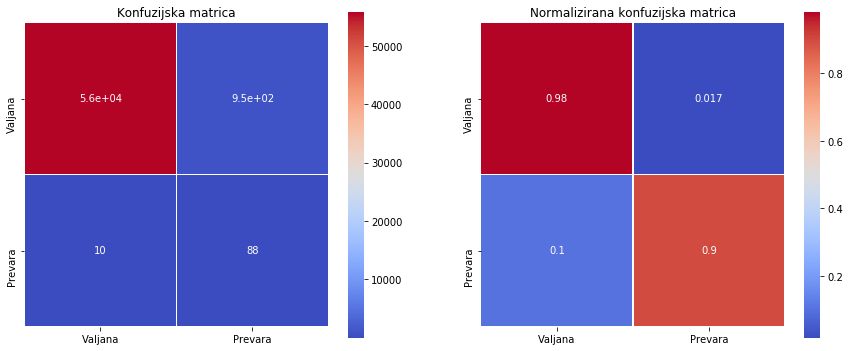

----------------------------------------------------------------------------------------------------


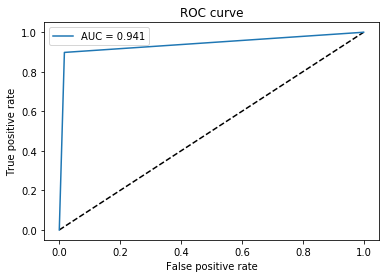

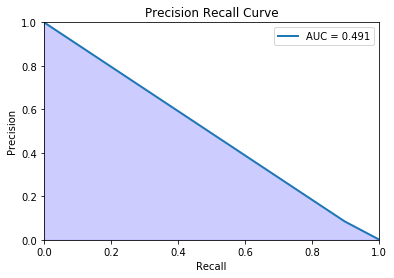

In [131]:
full_pred_svc_params_cut = svc_est_cut.predict(X_data_test)
full_score_svc_params_cut = svc_est_cut.predict_proba(X_data_test)[:, 1]
print_everything(y_data_test, full_pred_svc_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_svc_params_cut, True)

Koristeći metodu potpornih vektora dobili smo dosta višu preciznost (8.27%) i f1-mjeru (15.16%), dok je osjetljivost kao i kod većine klasifikatora 90.82%. To znači da opet imamo 89 ispravno klasificiranih prevara (jedanko kao i najbliži susjedi), dok je pogrešno klasificirano svega ~990 valjanih transakcija (~500 manje nego najbliži susjedi).

### Boosting

In [132]:
grid_xgb_cut = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb_cut.fit(X_usample_train_cut, y_usample_train_cut)
xgb_est_cut = grid_xgb_cut.best_estimator_
xgb_params_best_cut = grid_xgb_cut.best_params_

In [133]:
grid_lgbm_cut = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm_cut.fit(X_usample_train_cut, y_usample_train_cut)
lgbm_est_cut = grid_lgbm_cut.best_estimator_
lgbm_params_best_cut = grid_lgbm_cut.best_params_

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", li

In [134]:
grid_cat_cut = GridSearchCV(CatBoostClassifier(silent=True), cat_params)
grid_cat_cut.fit(X_usample_train_cut, y_usample_train_cut)
cat_est_cut = grid_cat_cut.best_estimator_
cat_params_best_cut = grid_cat_cut.best_params_

In [135]:
grid_ada_cut = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
grid_ada_cut.fit(X_usample_train_cut, y_usample_train_cut)
ada_est_cut = grid_ada_cut.best_estimator_
ada_params_best_cut = grid_ada_cut.best_params_

In [136]:
xgb_training_score_params_usample_cut = cross_val_score(xgb_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
lgbm_training_score_params_usample_cut = cross_val_score(lgbm_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
cat_training_score_params_usample_cut = cross_val_score(cat_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
ada_training_score_params_usample_cut = cross_val_score(ada_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)

print('Treniranje (sa parametrima, nakon izbacivanja outliera)')
print('-'*100)
print('XGB')
print('Najbolji parametri: ' + str(xgb_params_best_cut))
print('Rezultat treniranja: ' + str(round(xgb_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('LGBM')
print('Najbolji parametri: ' + str(lgbm_params_best_cut))
print('Rezultat treniranja: ' + str(round(lgbm_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('CatBoost')
print('Najbolji parametri: ' + str(cat_params_best_cut))
print('Rezultat treniranja: ' + str(round(cat_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('AdaBoost')
print('Najbolji parametri: ' + str(ada_params_best_cut))
print('Rezultat treniranja: ' + str(round(ada_training_score_params_usample_cut.mean(), 4) * 100) + '%')


Treniranje (sa parametrima, nakon izbacivanja outliera)
----------------------------------------------------------------------------------------------------
XGB
Najbolji parametri: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Rezultat treniranja: 93.47999999999999%
----------------------------------------------------------------------------------------------------
LGBM
Najbolji parametri: {'boosting_type': 'dart', 'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}
Rezultat treniranja: 93.07%
----------------------------------------------------------------------------------------------------
CatBoost
Najbolji parametri: {'depth': 7, 'learning_rate': 0.05, 'n_estimators': 50}
Rezultat treniranja: 92.75%
----------------------------------------------------------------------------------------------------
AdaBoost
Najbolji parametri: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 5, '

****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.6899999999999995%
	Recall score: 92.86%
	F1 score: 10.73%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.93      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


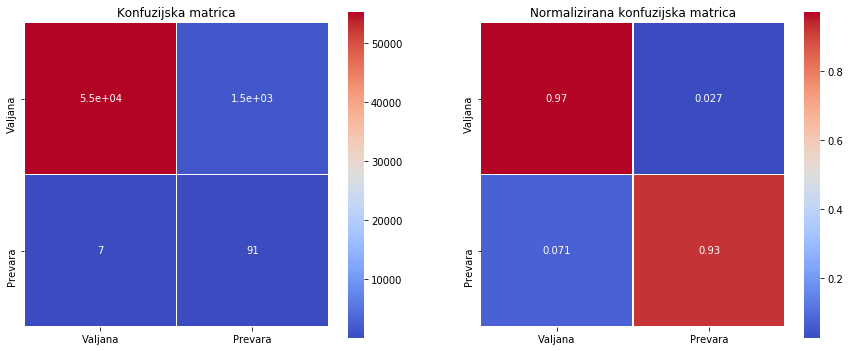

----------------------------------------------------------------------------------------------------


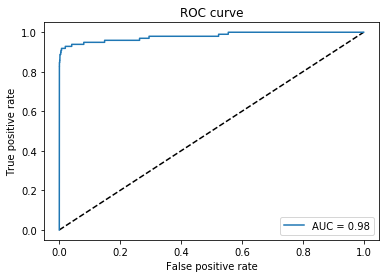

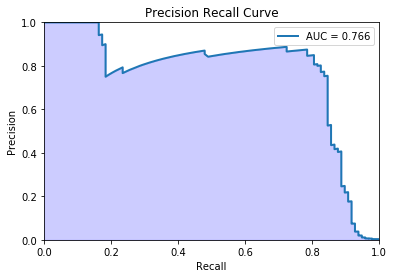

----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Machine)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.89%
	Recall score: 92.86%
	F1 score: 9.29%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


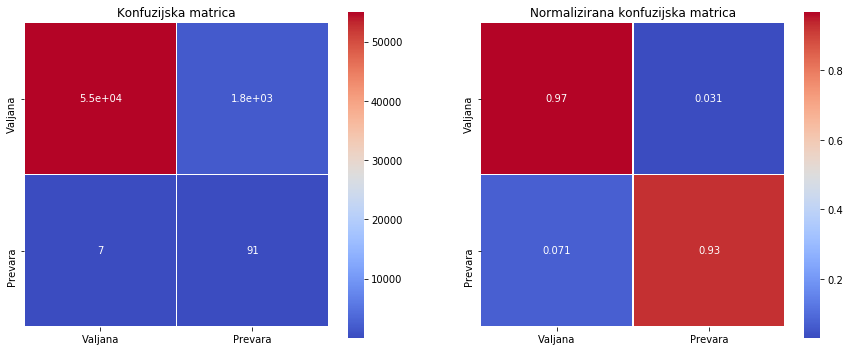

----------------------------------------------------------------------------------------------------


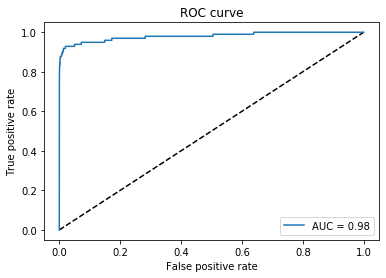

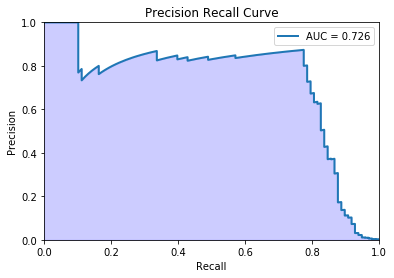

----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.09%
	Recall score: 91.84%
	F1 score: 14.879999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.92      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


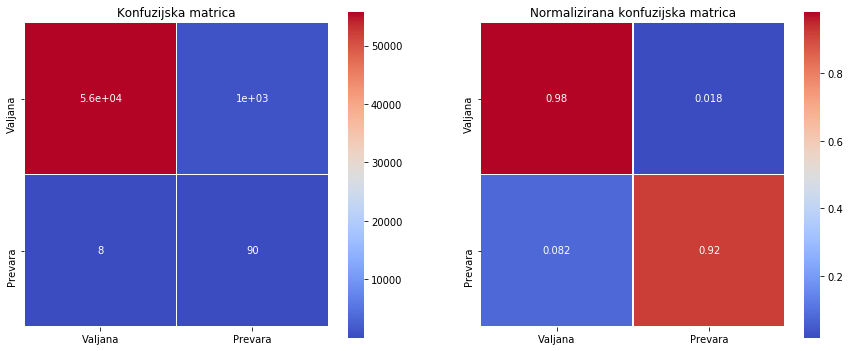

----------------------------------------------------------------------------------------------------


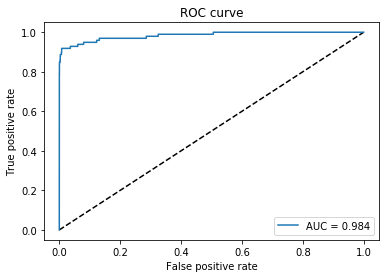

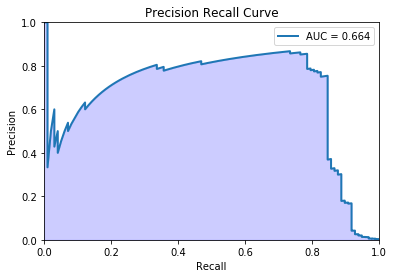

----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.31%
	Recall score: 92.86%
	F1 score: 16.93%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.93      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.96      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


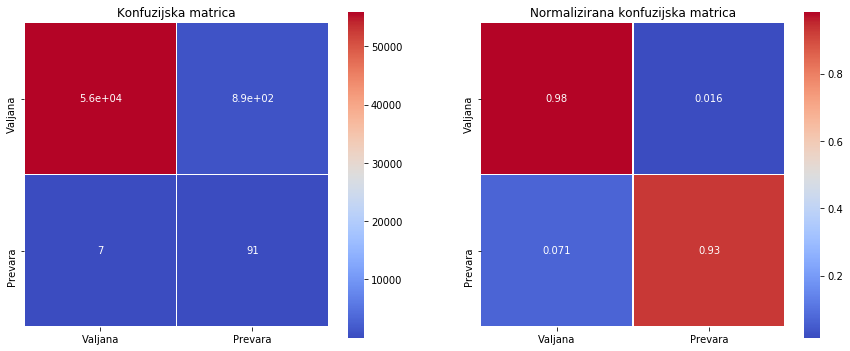

----------------------------------------------------------------------------------------------------


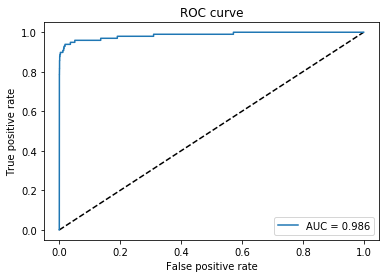

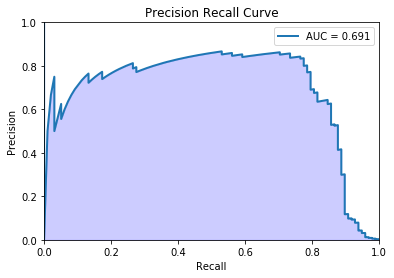

****************************************************************************************************


In [137]:
full_pred_xgb_params_cut = xgb_est_cut.predict(X_data_test)
full_score_xgb_params_cut = xgb_est_cut.predict_proba(X_data_test)[:, 1]

full_pred_lgbm_params_cut = lgbm_est_cut.predict(X_data_test)
full_score_lgbm_params_cut = lgbm_est_cut.predict_proba(X_data_test)[:, 1]

full_pred_cat_params_cut = cat_est_cut.predict(X_data_test)
full_score_cat_params_cut = cat_est_cut.predict_proba(X_data_test)[:, 1]

full_pred_ada_params_cut = ada_est_cut.predict(X_data_test)
full_score_ada_params_cut = ada_est_cut.predict_proba(X_data_test)[:, 1]

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_xgb_params_cut, True)
print('-'*100)
print("LGBM (Light Gradient Boosting Machine)")
print_everything(y_data_test, full_pred_lgbm_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_lgbm_params_cut, True)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_cat_params_cut, True)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_ada_params_cut, True)
print('*'*100)

Za sve boosting algoritme dobili smo slične rezultate. Osjetljivost je jako visoka (za XGB je 94.9%, za LGBM 93.88%, za CatBoost 92.86%, te za AdaBoost 93.88%). Preciznost i f1-mjera su nešto slabiji nego kod većine prijašnjih algoritama (ali nisu preniski). Kada za klasifikator koristimo XGB dobili smo oko 2100 pogrešno klasificiranih valjanih transakcija te čak 93 ispravno klasificirane prevare, za LGBM smo dobili oko 2200 pogrešno klasificiranih valjanih transakcija te 92 ispravno klasificirane prevare (oboje slabije nego kod XGB-a). Za CatBoost smo dobili nešto manje pogrešno klasificiranih valjanih transakcija (oko 1400), ali i manje ispravno klasificiranih prevara (91). AdaBoostom smo dobili nešto slabije rezultate nego LGBM-om (jednako ispravno klasificiranih prevara - 92, ali i oko 2600 pogrešno klasificiranih valjanih transakcija (otprilike 400 više nego LGBM)).

## Redukcija dimenzionalnosti

<p> Sada ćemo se nakratko posvetiti algoritmima za redukciju dimenzionalnosti. Konkretno govorimo o <em>t-SNE</em> i <em>PCA</em>. Opišimo sada malo svaki od njih te prikažimo dobivene rezultate. </p>
<ul>
    <li><em>t-SNE (t-distributed Stochastic Neighbor Embedding)</em> - noviji algoritam koji koristi nelinearnu redukciju dimenzija. Odnosno, dijeli klase tako da granica nije ravna linija (pravac). </li>
    <li><em>PCA (Principal Component Analysis)</em> - ortogonalna linearna projekcija, inače standardan algoritam za redukciju deimnezionalnosti. </li>
</ul>

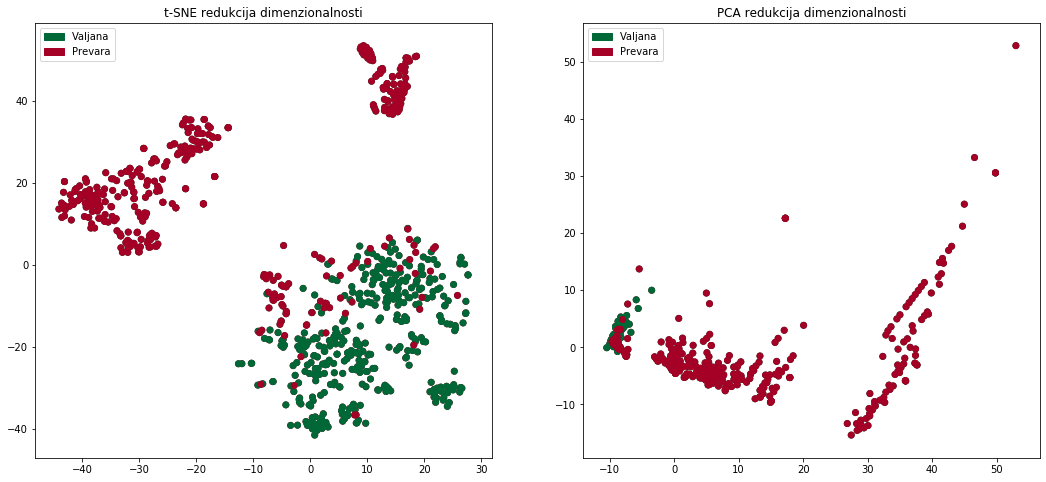

In [13]:
#t-SNE + PCA za skup podataka nakon undersamplinga
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib

cm = matplotlib.cm.get_cmap('RdYlGn_r')
red = cm(256)
green = cm(0)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_usample_train.values)
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_usample_train.values)


fig_tsne_pca, ax_tsne_pca = plt.subplots(1,2,figsize=(18,8))


non_fraud_patch = mpatches.Patch(color=green, label='Valjana')
fraud_patch = mpatches.Patch(color=red, label='Prevara')

ax_tsne_pca[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y_usample_train == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y_usample_train == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca[1].scatter(X_pca[:,0], X_pca[:,1], c=(y_usample_train == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca[1].scatter(X_pca[:,0], X_pca[:,1], c=(y_usample_train == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca[0].set_title('t-SNE redukcija dimenzionalnosti')
ax_tsne_pca[1].set_title('PCA redukcija dimenzionalnosti')

ax_tsne_pca[0].legend(handles=[non_fraud_patch, fraud_patch])
ax_tsne_pca[1].legend(handles=[non_fraud_patch, fraud_patch])

plt.show()

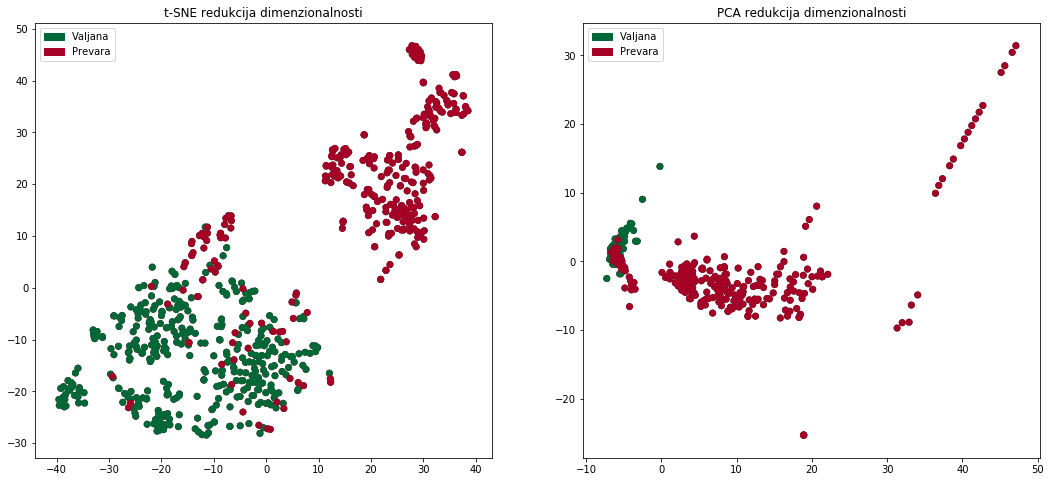

In [21]:
X_tsne_cut = TSNE(n_components=2, random_state=42).fit_transform(X_usample_train_cut.values)
X_pca_cut = PCA(n_components=2, random_state=42).fit_transform(X_usample_train_cut.values)


fig_tsne_pca_cut, ax_tsne_pca_cut = plt.subplots(1,2,figsize=(18,8))

non_fraud_patch = mpatches.Patch(color=green, label='Valjana')
fraud_patch = mpatches.Patch(color=red, label='Prevara')

ax_tsne_pca_cut[0].scatter(X_tsne_cut[:,0], X_tsne_cut[:,1], c=(y_usample_train_cut == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca_cut[0].scatter(X_tsne_cut[:,0], X_tsne_cut[:,1], c=(y_usample_train_cut == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca_cut[1].scatter(X_pca_cut[:,0], X_pca_cut[:,1], c=(y_usample_train_cut == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca_cut[1].scatter(X_pca_cut[:,0], X_pca_cut[:,1], c=(y_usample_train_cut == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca_cut[0].set_title('t-SNE redukcija dimenzionalnosti')
ax_tsne_pca_cut[1].set_title('PCA redukcija dimenzionalnosti')

ax_tsne_pca_cut[0].legend(handles=[non_fraud_patch, fraud_patch])
ax_tsne_pca_cut[1].legend(handles=[non_fraud_patch, fraud_patch])

plt.show()

Iz grafova vidimo da T-SNE transformacija puno bolje 'dijeli' klase nego PCA transformacija (to uključuje i prvi i drugi par grafova).